In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
import datetime
import gzip
import math
from dataclasses import dataclass
from functools import reduce

In [2]:
pattern_loop = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.core\.task\.single\.complete\.Cegis\w*: ===== Loop number #(\d+), N = (\d+) =====$'
pattern_optimize_top_down = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.core\.task\.Optimization: optimizeTopDown: < (\d+) -> (\d+) in (\d+,\d+) s$'
pattern_cegis_iteration = r'^\[(.+)\] \[DEBUG\] ru\.ifmo\.fbsat\.core\.task\.single\.complete\.Cegis: CEGIS iteration #(\d+) on loop (\d+)$'
pattern_cegis_iteration_done = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.core\.task\.single\.complete\.Cegis: CEGIS iteration #(\d+) done in (\d+,\d+) s$'
pattern_cegis_unsat = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.core\.task\.single\.complete\.Cegis\w*: UNSAT, N = (\d+) is too small, trying (?:to increase|larger value)...$'
pattern_all_done = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.cli\.Main: All done in (\d+,\d+) seconds$'

@dataclass
class TimestampedEvent:
    timestamp: float

@dataclass
class LoopEvent(TimestampedEvent):
    loop: int
    n: int

@dataclass
class OptimizeTopDownEvent(TimestampedEvent):
    from_n: int
    to_n: int
    duration: float

@dataclass
class CegisIterationEvent(TimestampedEvent):
    iteration: int
    loop: int

@dataclass
class CegisIterationDoneEvent(TimestampedEvent):
    iteration: int
    duration: float

@dataclass
class CegisUnsatEvent(TimestampedEvent):
    n: int
        
@dataclass
class AllDone(TimestampedEvent):
    duration: float

def parse_timestamp(s):
    a = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S,%f")
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S,%f").timetuple()) + 0.000001 * a.microsecond

def parse_duration(s):
    return float(s.replace(',', '.'))

def parse_logs(lines):
    answer = []
    for bline in lines:
        line = bline.decode()
        match = re.search(pattern_loop, line)
        if match:
            timestamp = parse_timestamp(match[1])
            loop = int(match[2])
            n = int(match[3])
            answer.append(LoopEvent(timestamp, loop, n))
            continue
        match = re.search(pattern_optimize_top_down, line)
        if match:
            timestamp = parse_timestamp(match[1])
            from_n = int(match[2])
            to_n = int(match[3])
            duration = parse_duration(match[4])
            answer.append(OptimizeTopDownEvent(timestamp, from_n, to_n, duration))
            continue
        match = re.search(pattern_cegis_iteration, line)
        if match:
            timestamp = parse_timestamp(match[1])
            iteration = int(match[2])
            loop = int(match[3])
            answer.append(CegisIterationEvent(timestamp, iteration, loop))
            continue
        match = re.search(pattern_cegis_iteration_done, line)
        if match:
            timestamp = parse_timestamp(match[1])
            iteration = int(match[2])
            duration = parse_duration(match[3])
            answer.append(CegisIterationDoneEvent(timestamp, iteration, duration))
            continue
        match = re.search(pattern_cegis_unsat, line)
        if match:
            timestamp = parse_timestamp(match[1])
            n = int(match[2])
            answer.append(CegisUnsatEvent(timestamp, n))
            continue
        match = re.search(pattern_all_done, line)
        if match:
            timestamp = parse_timestamp(match[1])
            duration = parse_duration(match[2])
            answer.append(AllDone(timestamp, duration))
            continue
    return answer
        
def parse_log_file(file):
    with gzip.open(file, 'r') as f:
        answer = parse_log(f.readlines())

def read_logs():
    return {file: parse_log(file) for file in os.listdir() if file.startswith('log')}

def get_or_put(d, key, value):
    d.setdefault(key, value)
    return d[key]

def set_dict(d, key, value):
    reduce(lambda dd, k: get_or_put(dd, k, dict()), key[:-1], d)[key[-1]] = value
    
def get_dict(d, key):
    return reduce(lambda dd, k: dd[k], key, d)

def get_stat(logs_pairs):
    stats = dict()
    for key in logs_pairs:
        num, length, i, seed = key
        ns = []
        for mode in ['assumptions', 'general']:
            with gzip.open("../" + logs_pairs[key][mode], 'r') as f:
                parsed = parse_logs(f.readlines())
                
            total_duration = None
            need_next_unsat = False
            loop = 0;
            iteration = 0;
            n = 0;
            ns_i = 0
            unsats = []
            done1s = []

            for event in parsed:
                if isinstance(event, LoopEvent):
                    n = event.n
                    loop = event.loop
                    if mode == 'assumptions':
                        ns.append(n)
                    if ns_i < len(ns) and ns[ns_i] < n:
                        ns_i += 1
                    continue
                if isinstance(event, OptimizeTopDownEvent):
                    continue
                if isinstance(event, CegisIterationEvent):
                    iteration = event.iteration
                    continue
                if isinstance(event, CegisIterationDoneEvent):
                    if iteration == 1 and ns_i < len(ns) and n == ns[ns_i]:
                        done1s.append(event.timestamp)
                    continue
                if isinstance(event, CegisUnsatEvent):
                    if ns_i < len(ns) and n == ns[ns_i]:
                        unsats.append(event.timestamp)
                    continue
                if isinstance(event, AllDone):
                    assert (total_duration is None)
                    total_duration = event.duration
                    continue
                print(event)
                assert False
                    
            if total_duration is None:
                print(logs_pairs[key][mode], mode)
            set_dict(stats, key + (f'{mode}_total_duration',), total_duration)
            set_dict(stats, key + (f'{mode}_between_loops_duration',), [done1s[i] - unsats[i - 1] for i in range(1, len(done1s))])
        set_dict(stats, key + ('faster_between_loops_duration',), {i + 1: math.log(a) - math.log(g) for i, (a, g) in enumerate(zip(get_dict(stats, key + ('assumptions_between_loops_duration',)), get_dict(stats, key + ('general_between_loops_duration',))))})
        for mode in ['assumptions', 'general']:
            set_dict(stats, key + (f'{mode}_between_loops_duration',), {i + 1: dur for i, dur in enumerate(get_dict(stats, key + (f'{mode}_between_loops_duration',)))})
        ass_total_dur = get_dict(stats, key + ('assumptions_total_duration',))
        gen_total_dur = get_dict(stats, key + ('general_total_duration',))
        if ass_total_dur is not None and gen_total_dur is not None:
            set_dict(stats, key + ('faster_duration',), math.log(ass_total_dur) - math.log(gen_total_dur))
    return stats

pattern_logs_position_line = r'^out/gen/traces_(\d+)_(\d+)_(\d+)\.gz/(\w+)/(\d+) (logs/fbsat_\d+_\d+\.log\.gz)$'
def get_logs_pairs():
    with open("../logs_position") as f:
        params2logs = {((int(match[1]), int(match[2]), int(match[3]), int(match[5])), match[4]): match[6] for match in [re.search(pattern_logs_position_line, line) for line in f.readlines()]}
        num_params = {opts for opts, mode in params2logs}
        return {opts: {"assumptions": params2logs[(opts, "assumptions")], "general": params2logs[(opts, "general")]} for opts in num_params if (opts, "assumptions") in params2logs and (opts, "general") in params2logs}

In [3]:
#parsed = read_logs()
#parse_log_file('fbsat_20210402_91.log.gz')

stats = get_stat(get_logs_pairs())
print(stats)

logs/fbsat_20210410_47.log.gz assumptions
logs/fbsat_20210410_81.log.gz assumptions
logs/fbsat_20210411_136.log.gz general
logs/fbsat_20210402_154.log.gz general
logs/fbsat_20210402_203.log.gz assumptions
logs/fbsat_20210402_202.log.gz general
logs/fbsat_20210402_24.log.gz general
logs/fbsat_20210410_63.log.gz assumptions
logs/fbsat_20210410_62.log.gz general
logs/fbsat_20210329_170.log.gz assumptions
logs/fbsat_20210329_169.log.gz general
logs/fbsat_20210329_145.log.gz general
logs/fbsat_20210411_50.log.gz assumptions
logs/fbsat_20210411_49.log.gz general
logs/fbsat_20210402_43.log.gz assumptions
logs/fbsat_20210329_113.log.gz general
logs/fbsat_20210411_247.log.gz assumptions
logs/fbsat_20210411_246.log.gz general
logs/fbsat_20210411_95.log.gz assumptions
logs/fbsat_20210411_221.log.gz assumptions
logs/fbsat_20210402_69.log.gz assumptions
logs/fbsat_20210402_68.log.gz general
logs/fbsat_20210411_103.log.gz assumptions
logs/fbsat_20210411_157.log.gz assumptions
logs/fbsat_20210411_48.

In [77]:
def extract_info(stats, keys):
    result = dict()
    def extract_info_impl(s, i, k, fk):
        if not isinstance(s, dict):
            result[fk] = s
            return
        for j in s:
            if len(k) != 0 and k[0][0] == i:
                if j in k[0][1]:
                    extract_info_impl(s[j], i + 1, k[1:], fk + (j,))
            else:
                extract_info_impl(s[j], i + 1, k, fk + (j,))
    extract_info_impl(stats, 0, keys, ())
    return result

def split_coordinates(x, y, bad=90):
    x_gray = [x[i] for i in range(len(x)) if y[i] <= bad and x[i] <= bad]
    y_gray = [y[i] for i in range(len(x)) if y[i] <= bad and x[i] <= bad]
    x_red = [x[i] for i in range(len(x)) if y[i] > x[i] + 0.1 and (y[i] > bad or x[i] > bad)]
    y_red = [y[i] for i in range(len(x)) if y[i] > x[i] + 0.1 and (y[i] > bad or x[i] > bad)]
    x_green = [x[i] for i in range(len(x)) if y[i] < x[i] - 0.1 and (y[i] > bad or x[i] > bad)]
    y_green = [y[i] for i in range(len(x)) if y[i] < x[i] - 0.1 and (y[i] > bad or x[i] > bad)]
    x_blue = [x[i] for i in range(len(x)) if y[i] > x[i] - 0.1 and y[i] < x[i] + 0.1 and (y[i] > bad or x[i] > bad)]
    y_blue = [y[i] for i in range(len(x)) if y[i] > x[i] - 0.1 and y[i] < x[i] + 0.1 and (y[i] > bad or x[i] > bad)]
    return x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray

<ipython-input-114-bee5dc09501b>:19: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


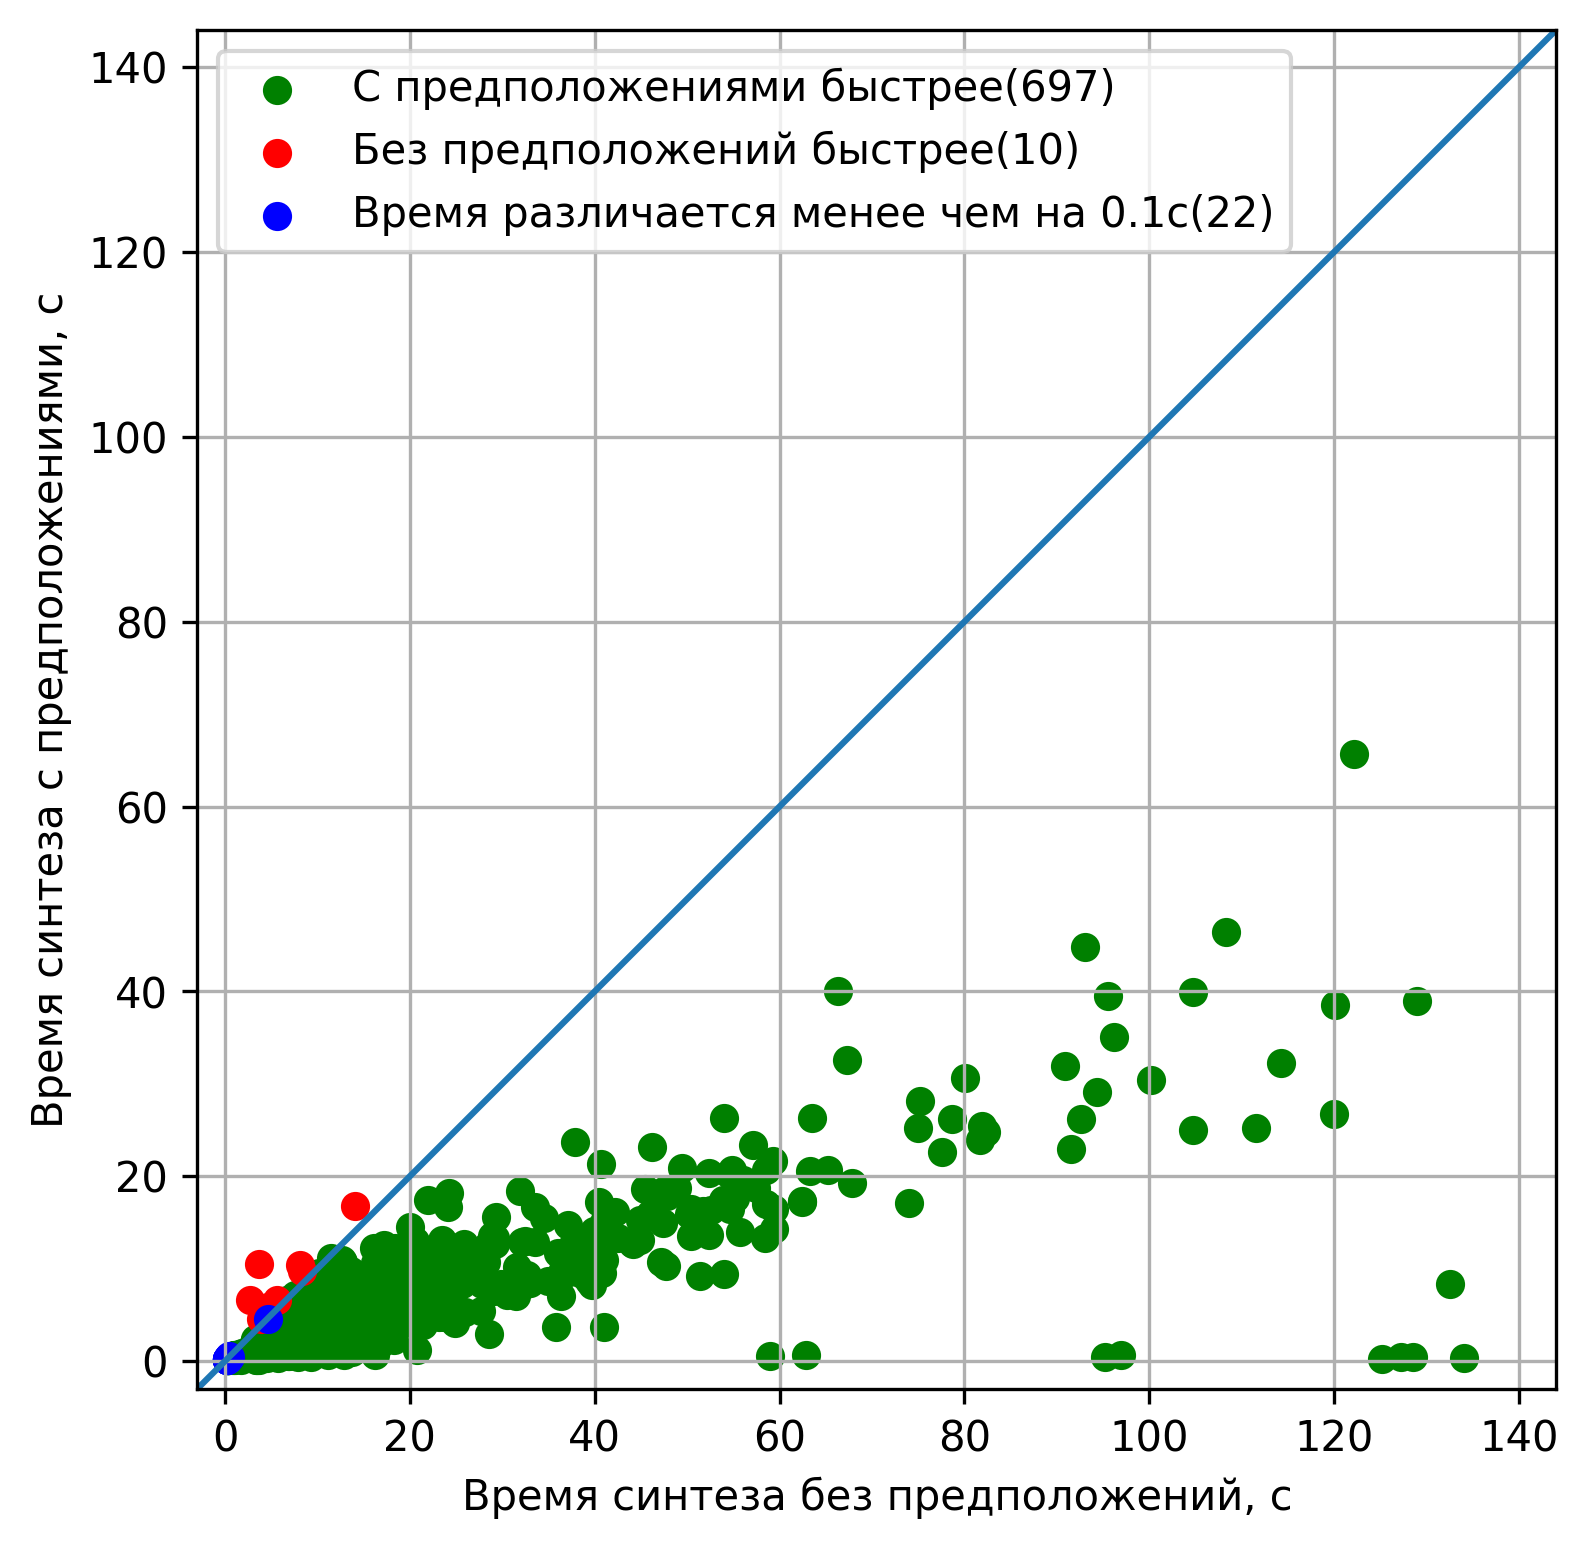

In [114]:
plt.figure(figsize=(8,6), dpi= 300)
#sns.kdeplot(extract_info(stats, [(4, {'faster_between_loops_duration'})]), label="Between loops", alpha=.7)
#sns.boxplot(extract_info(stats, [(4, {'faster_between_loops_duration'})]))
#sns.kdeplot(extract_info(stats, [(4, {'faster_duration'})]), label="Total", alpha=.7)
#sns.boxplot(extract_info(stats, [(4, {'faster_duration'})]))

info = extract_info(stats, [(4, {'assumptions_between_loops_duration', 'general_between_loops_duration'})])
keys = list({k[:4] + k[5:] for k in info if k[:4] + ('assumptions_between_loops_duration',) + k[5:] in info and k[:4] + ('general_between_loops_duration',) + k[5:] in info})
y = [info[k[:4] + ('assumptions_between_loops_duration',) + k[4:]] for k in keys]
x = [info[k[:4] + ('general_between_loops_duration'    ,) + k[4:]] for k in keys]
x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y, 0)

plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
plt.scatter(x_blue, y_blue, color='blue', label=f'Время различается менее чем на 0.1с({len(x_blue)})')
#plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
mx = max(max(x), max(y))
plt.plot([-3, mx + 10], [-3, mx + 10])
plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

#plt.title('Время между предыдущим UNSAT и первым SAT', fontsize=22)
plt.xlabel('Время синтеза без предположений, с')
plt.ylabel('Время синтеза с предположениями, с')
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

<ipython-input-115-2786810a37e8>:15: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


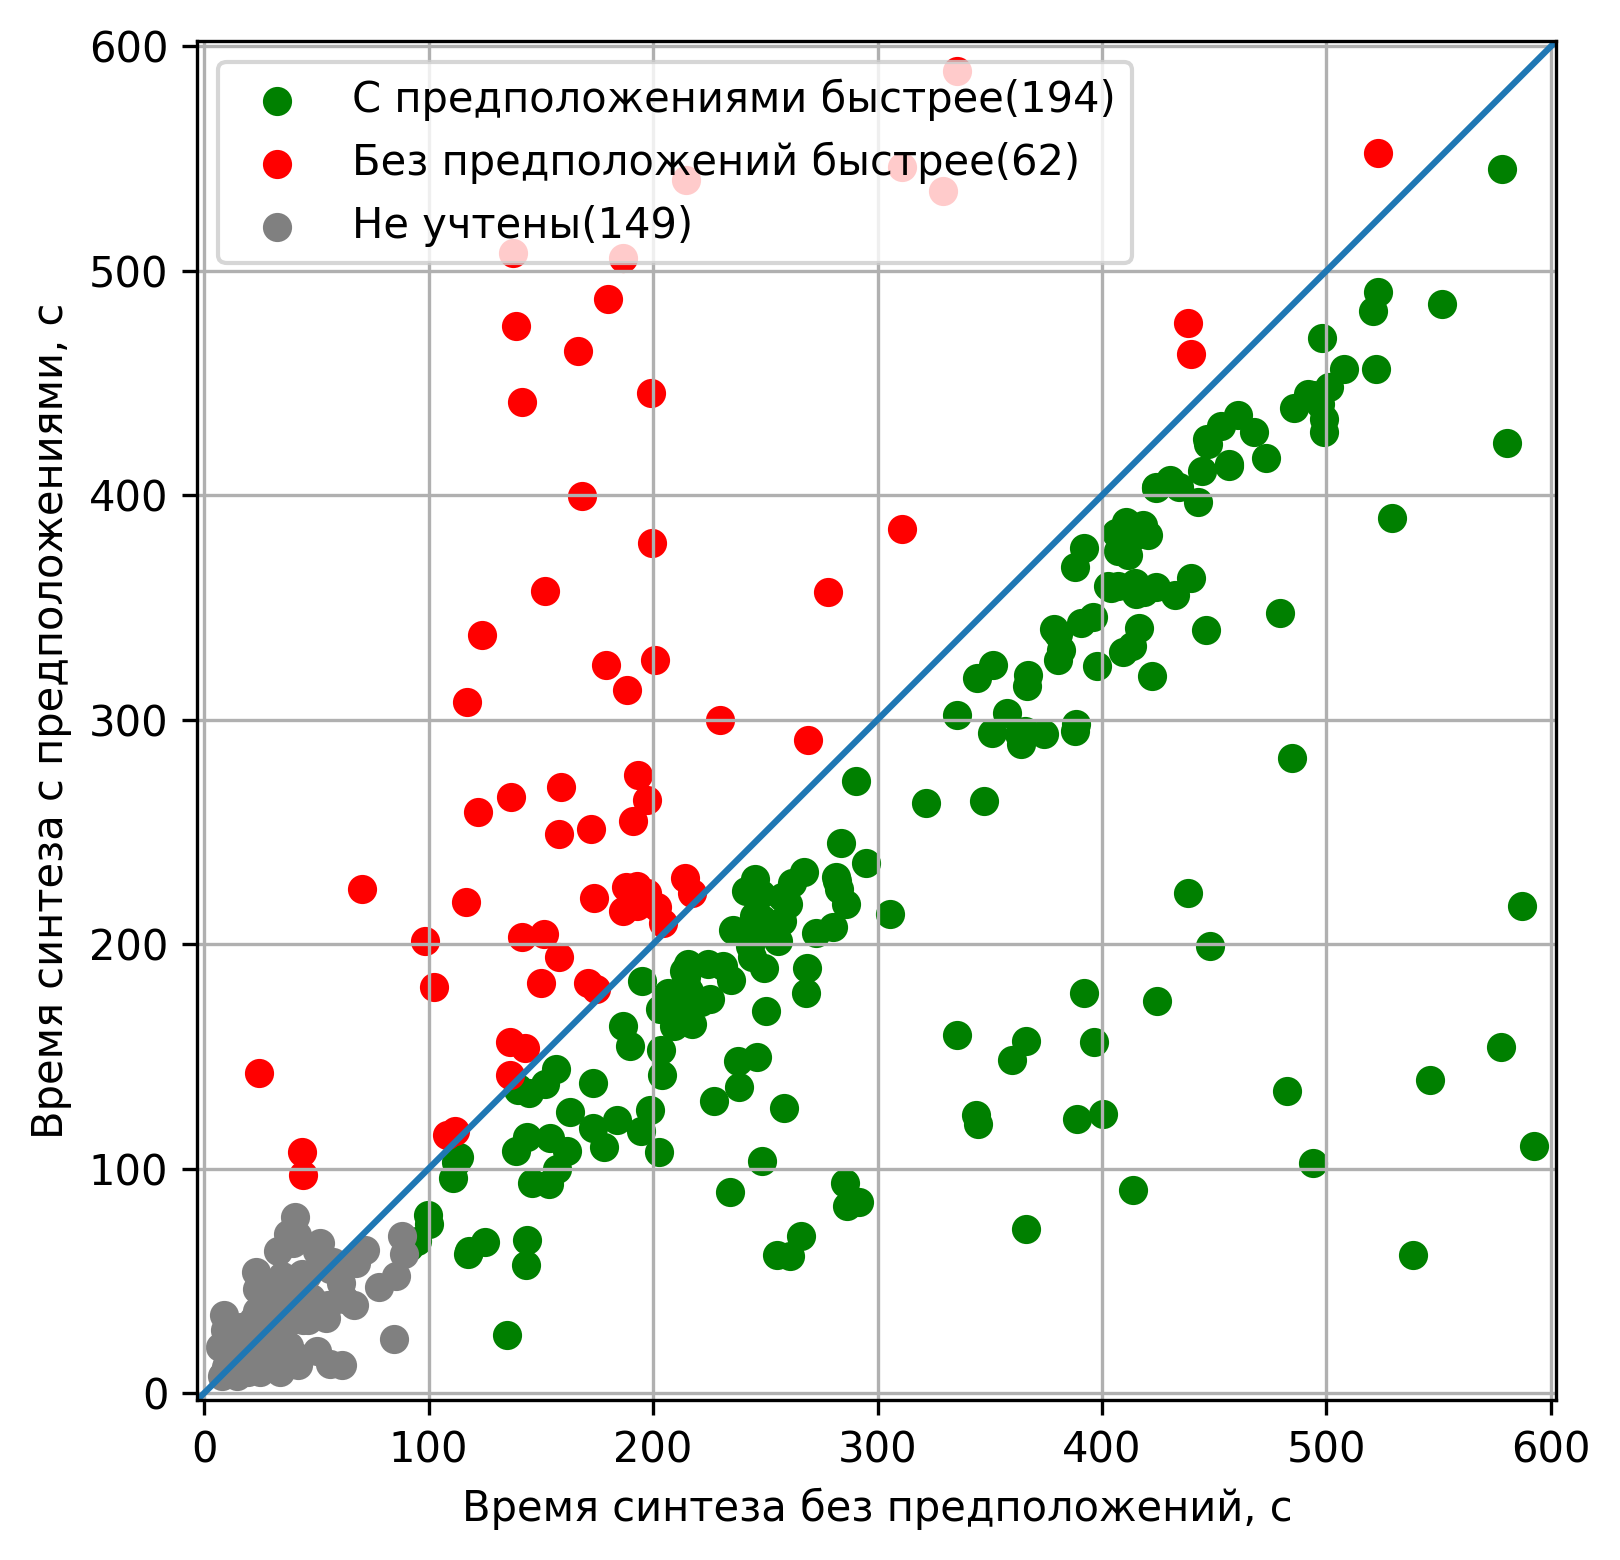

In [115]:
plt.figure(figsize=(8,6), dpi= 300)

info = extract_info(stats, [(4, {'assumptions_total_duration', 'general_total_duration'})])
keys = list({k[:4] for k in info if info[k[:4] + ('assumptions_total_duration',)] is not None and info[k[:4] + ('general_total_duration',)] is not None})
y = [info[k[:4] + ('assumptions_total_duration',)] for k in keys]
x = [info[k[:4] + ('general_total_duration'    ,)] for k in keys]
x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y)

plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
#plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
mx = max(max(x), max(y))
plt.plot([-3, mx + 10], [-3, mx + 10])
plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

#plt.title('Время синтеза', fontsize=22)
plt.xlabel('Время синтеза без предположений, с')
plt.ylabel('Время синтеза с предположениями, с')
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

<ipython-input-109-ca0b2de61c4a>:18: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


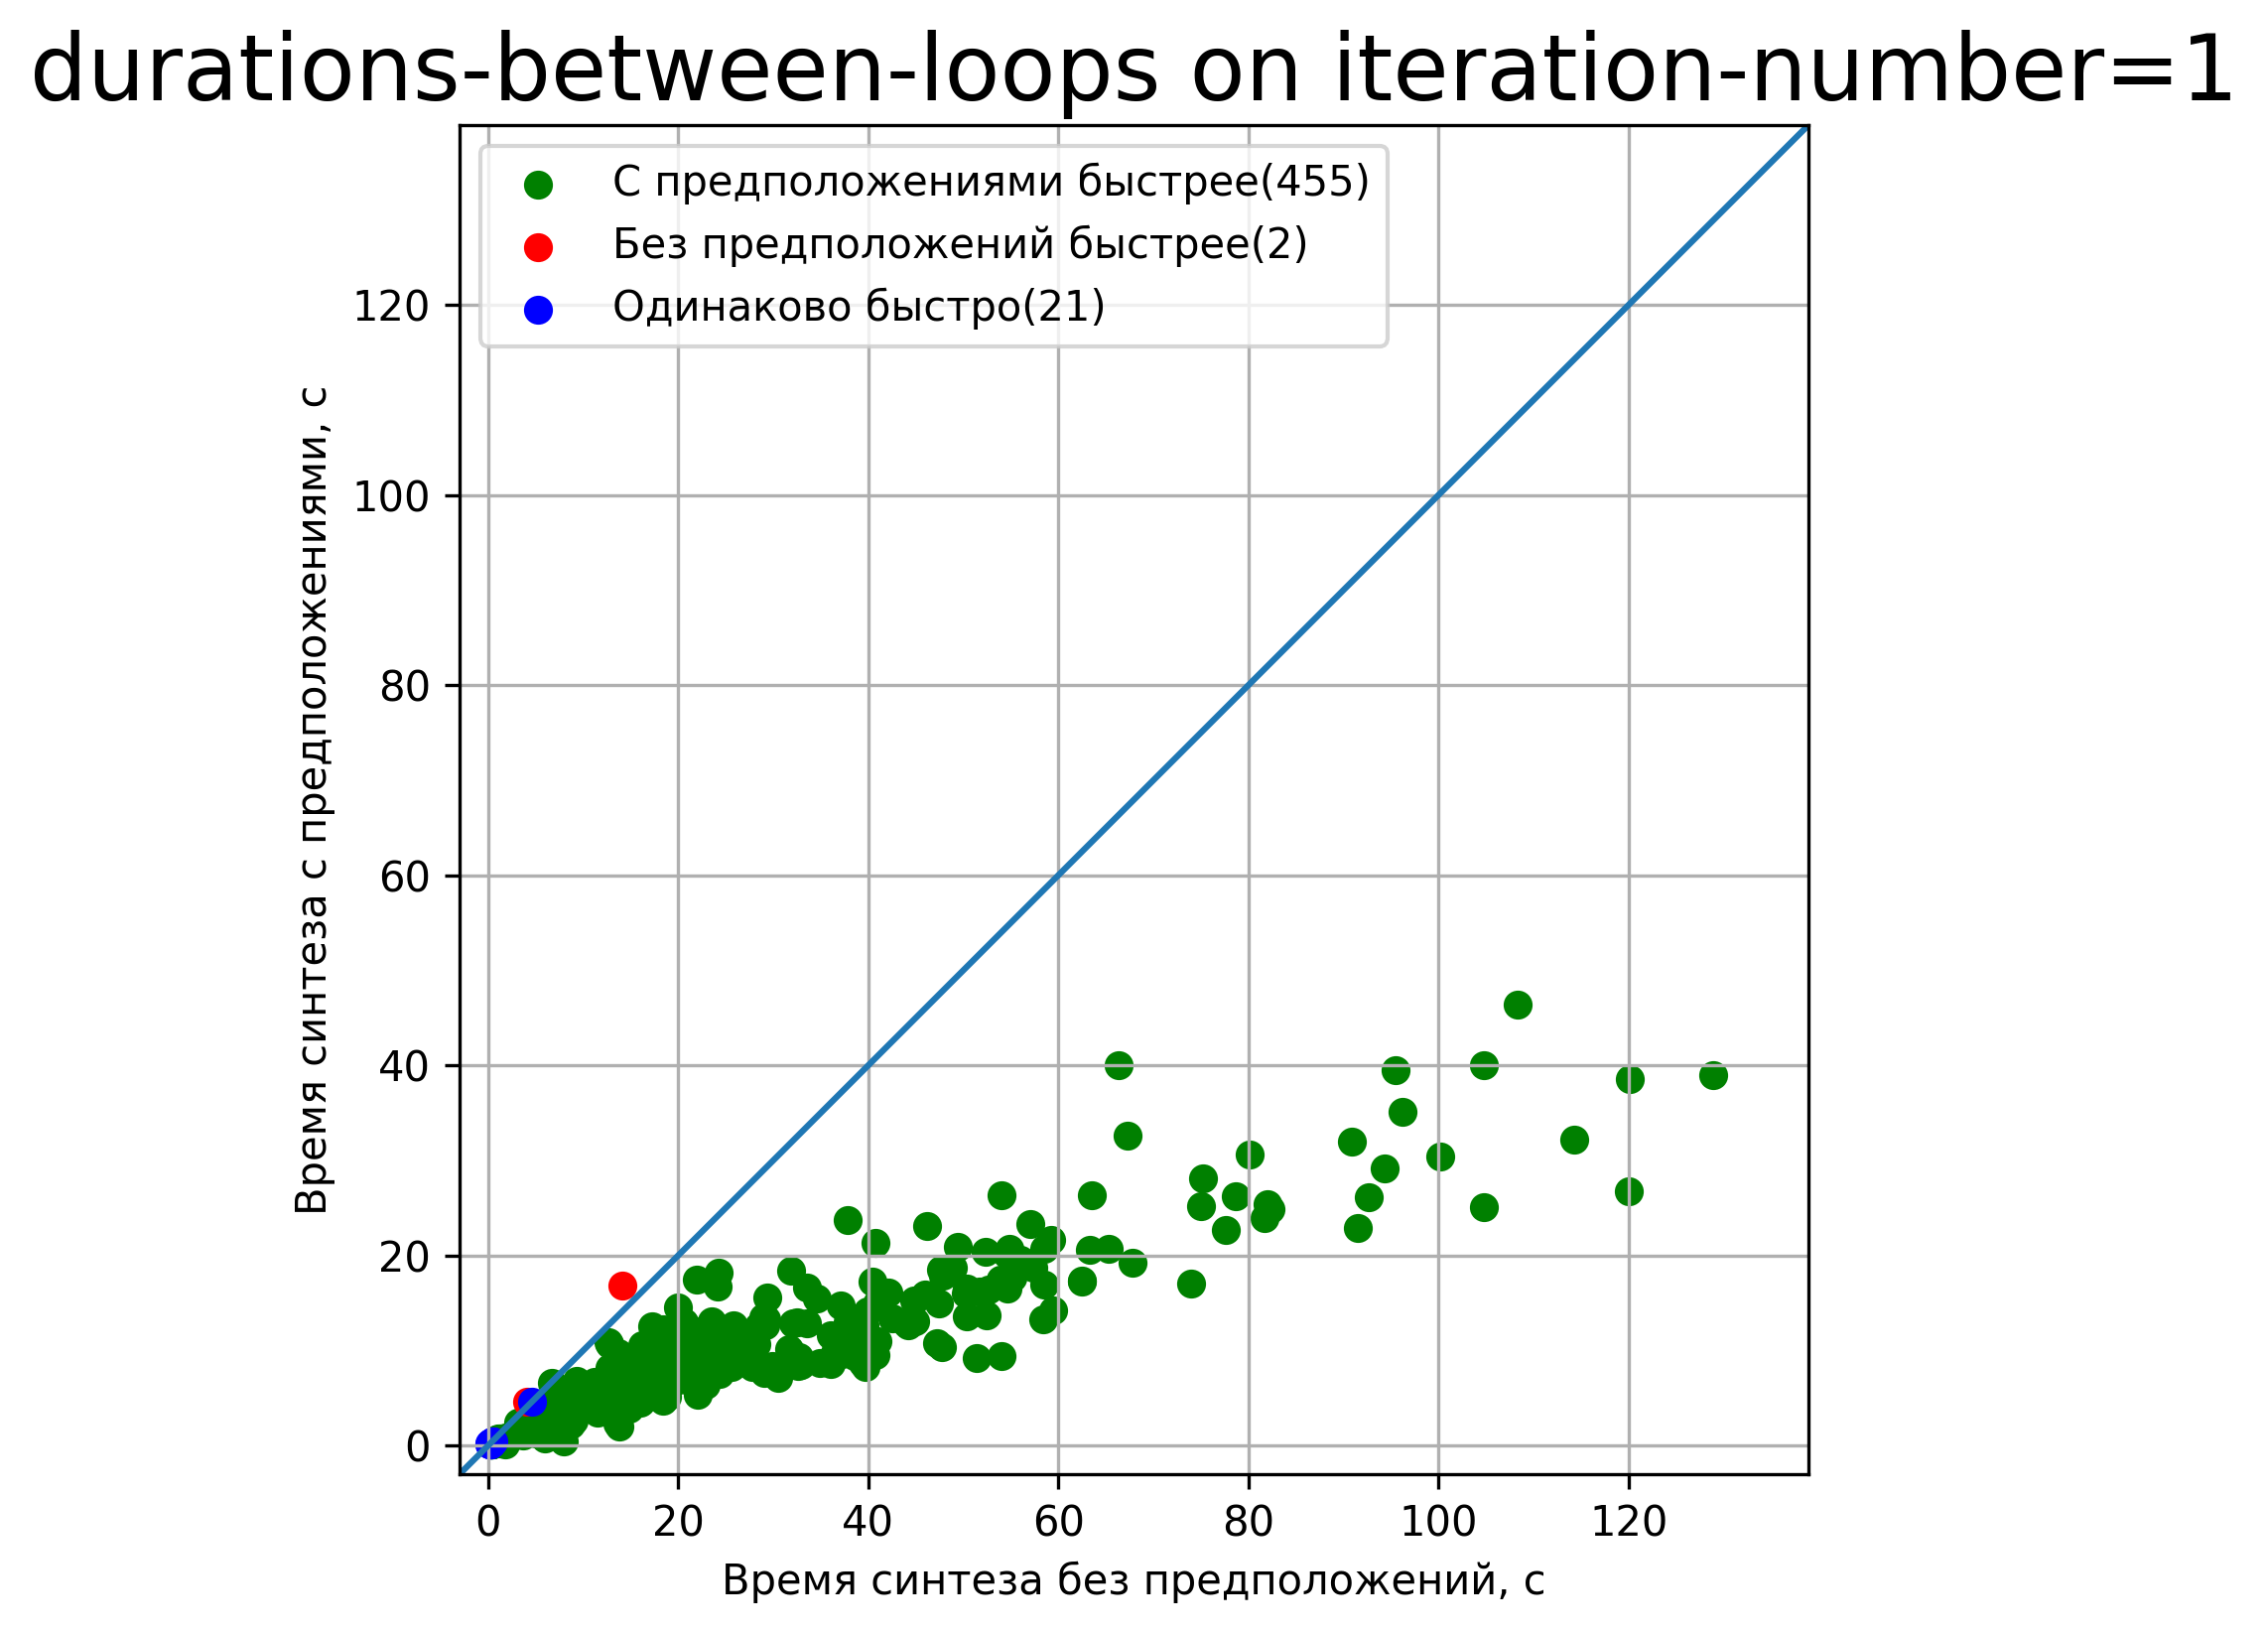

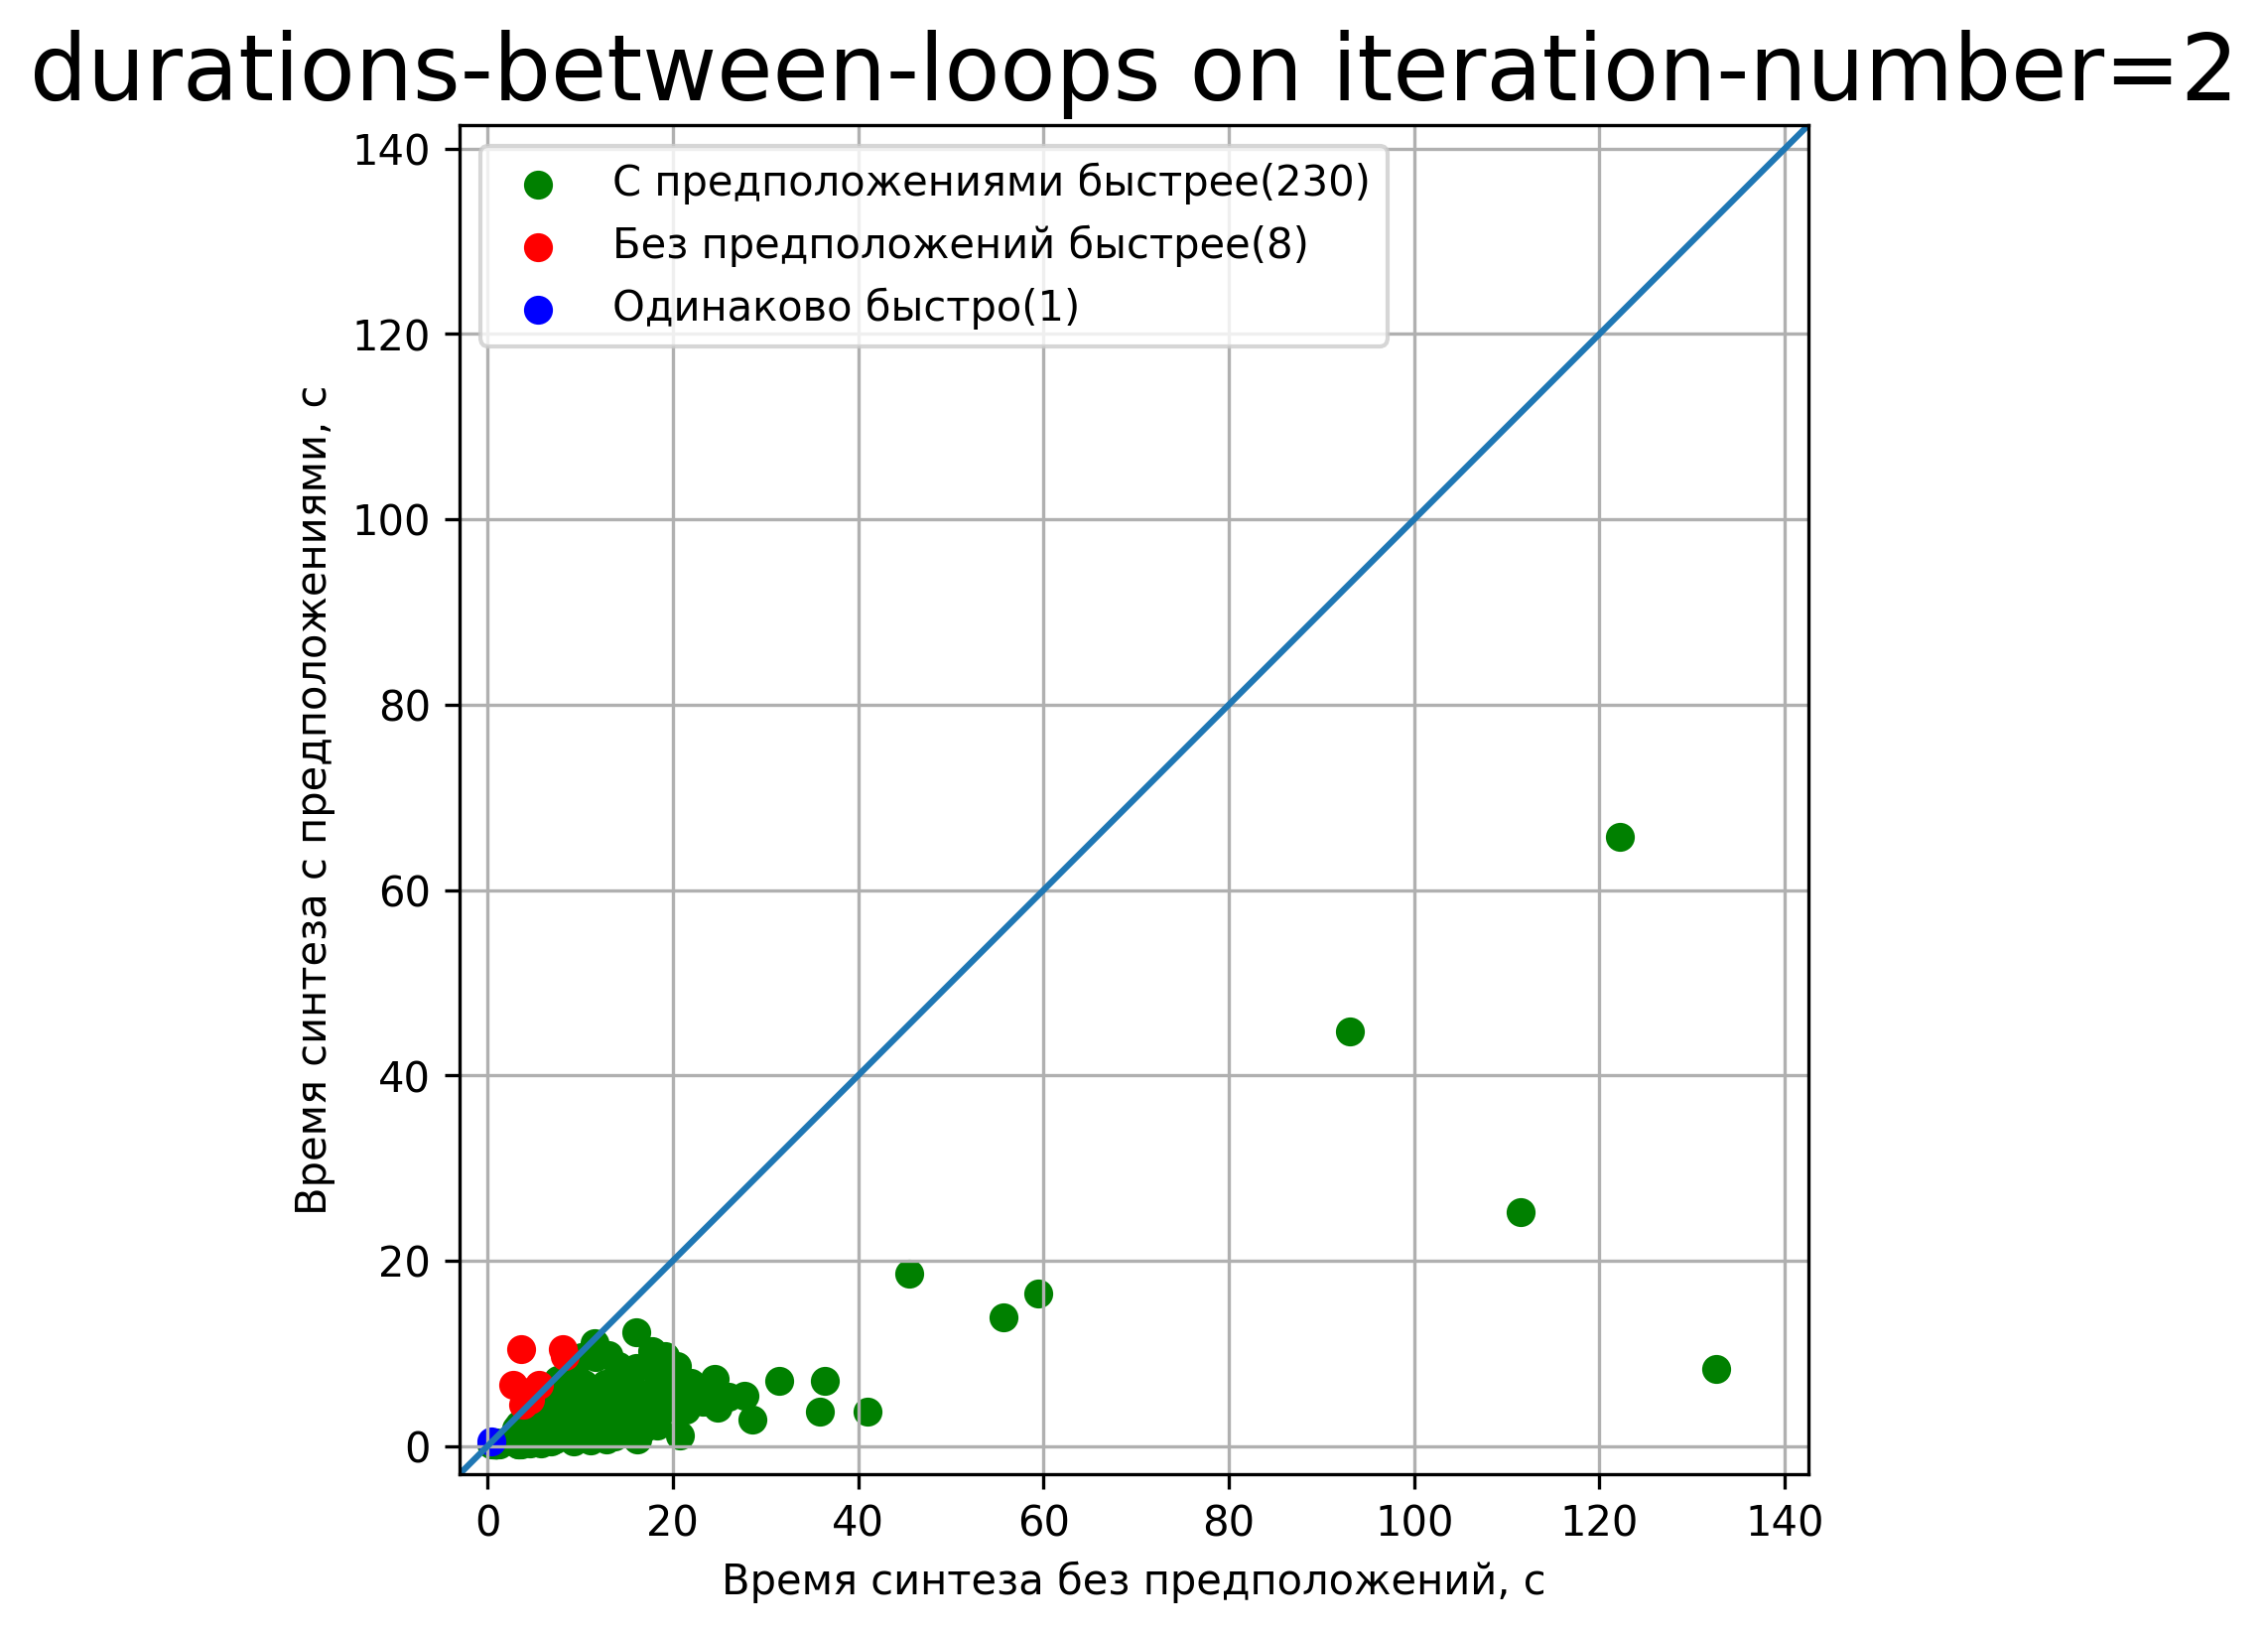

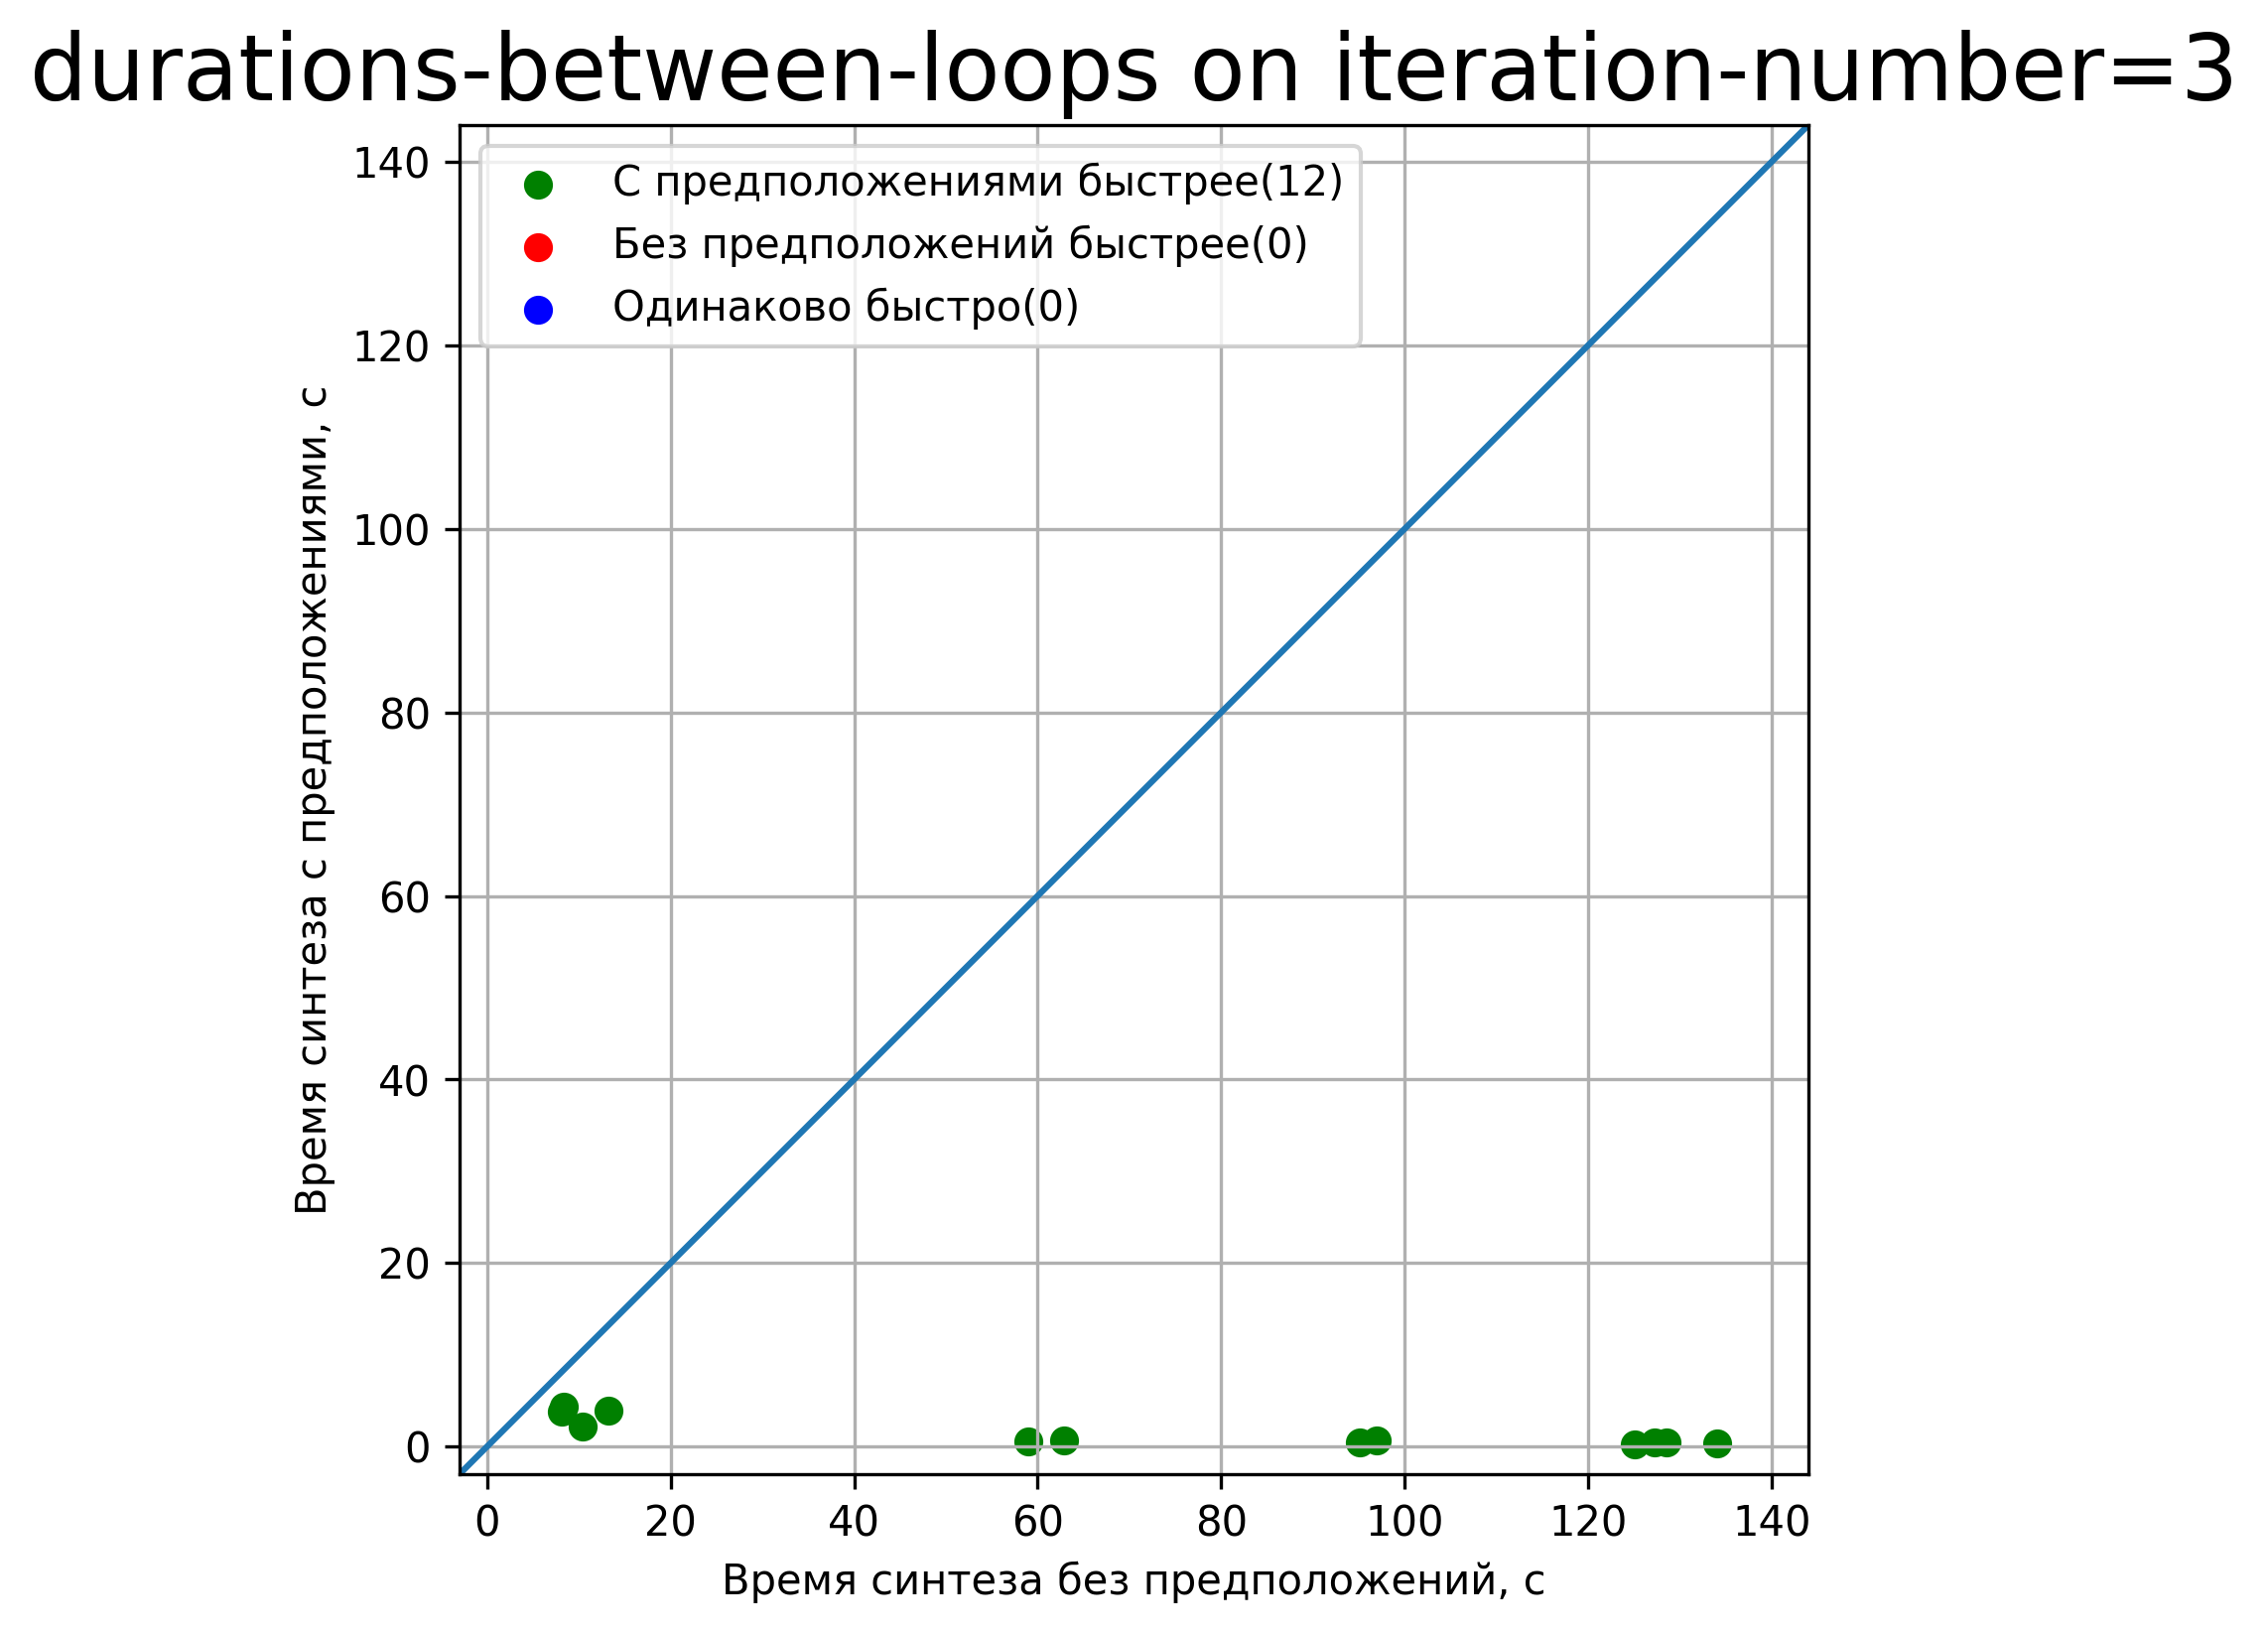

<Figure size 2400x1800 with 0 Axes>

In [109]:
for i in range(1, 100):
    plt.figure(figsize=(8,6), dpi=300)

    info = extract_info(stats, [(4, {'assumptions_between_loops_duration', 'general_between_loops_duration'}), (5, {i})])
    if len(info) == 0:
        break
    keys = list({k[:4] + k[5:] for k in info if k[:4] + ('assumptions_between_loops_duration',) + k[5:] in info and k[:4] + ('general_between_loops_duration',) + k[5:] in info})
    y = [info[k[:4] + ('assumptions_between_loops_duration',) + k[4:]] for k in keys]
    x = [info[k[:4] + ('general_between_loops_duration'    ,) + k[4:]] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y, 0)
    
    plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
    #plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    mx = max(max(x), max(y))
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')
    
    plt.title(f'durations-between-loops on iteration-number={i}', fontsize=22)
    plt.xlabel('Время синтеза без предположений, с')
    plt.ylabel('Время синтеза с предположениями, с')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()

<ipython-input-110-db39e0ec6e11>:15: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


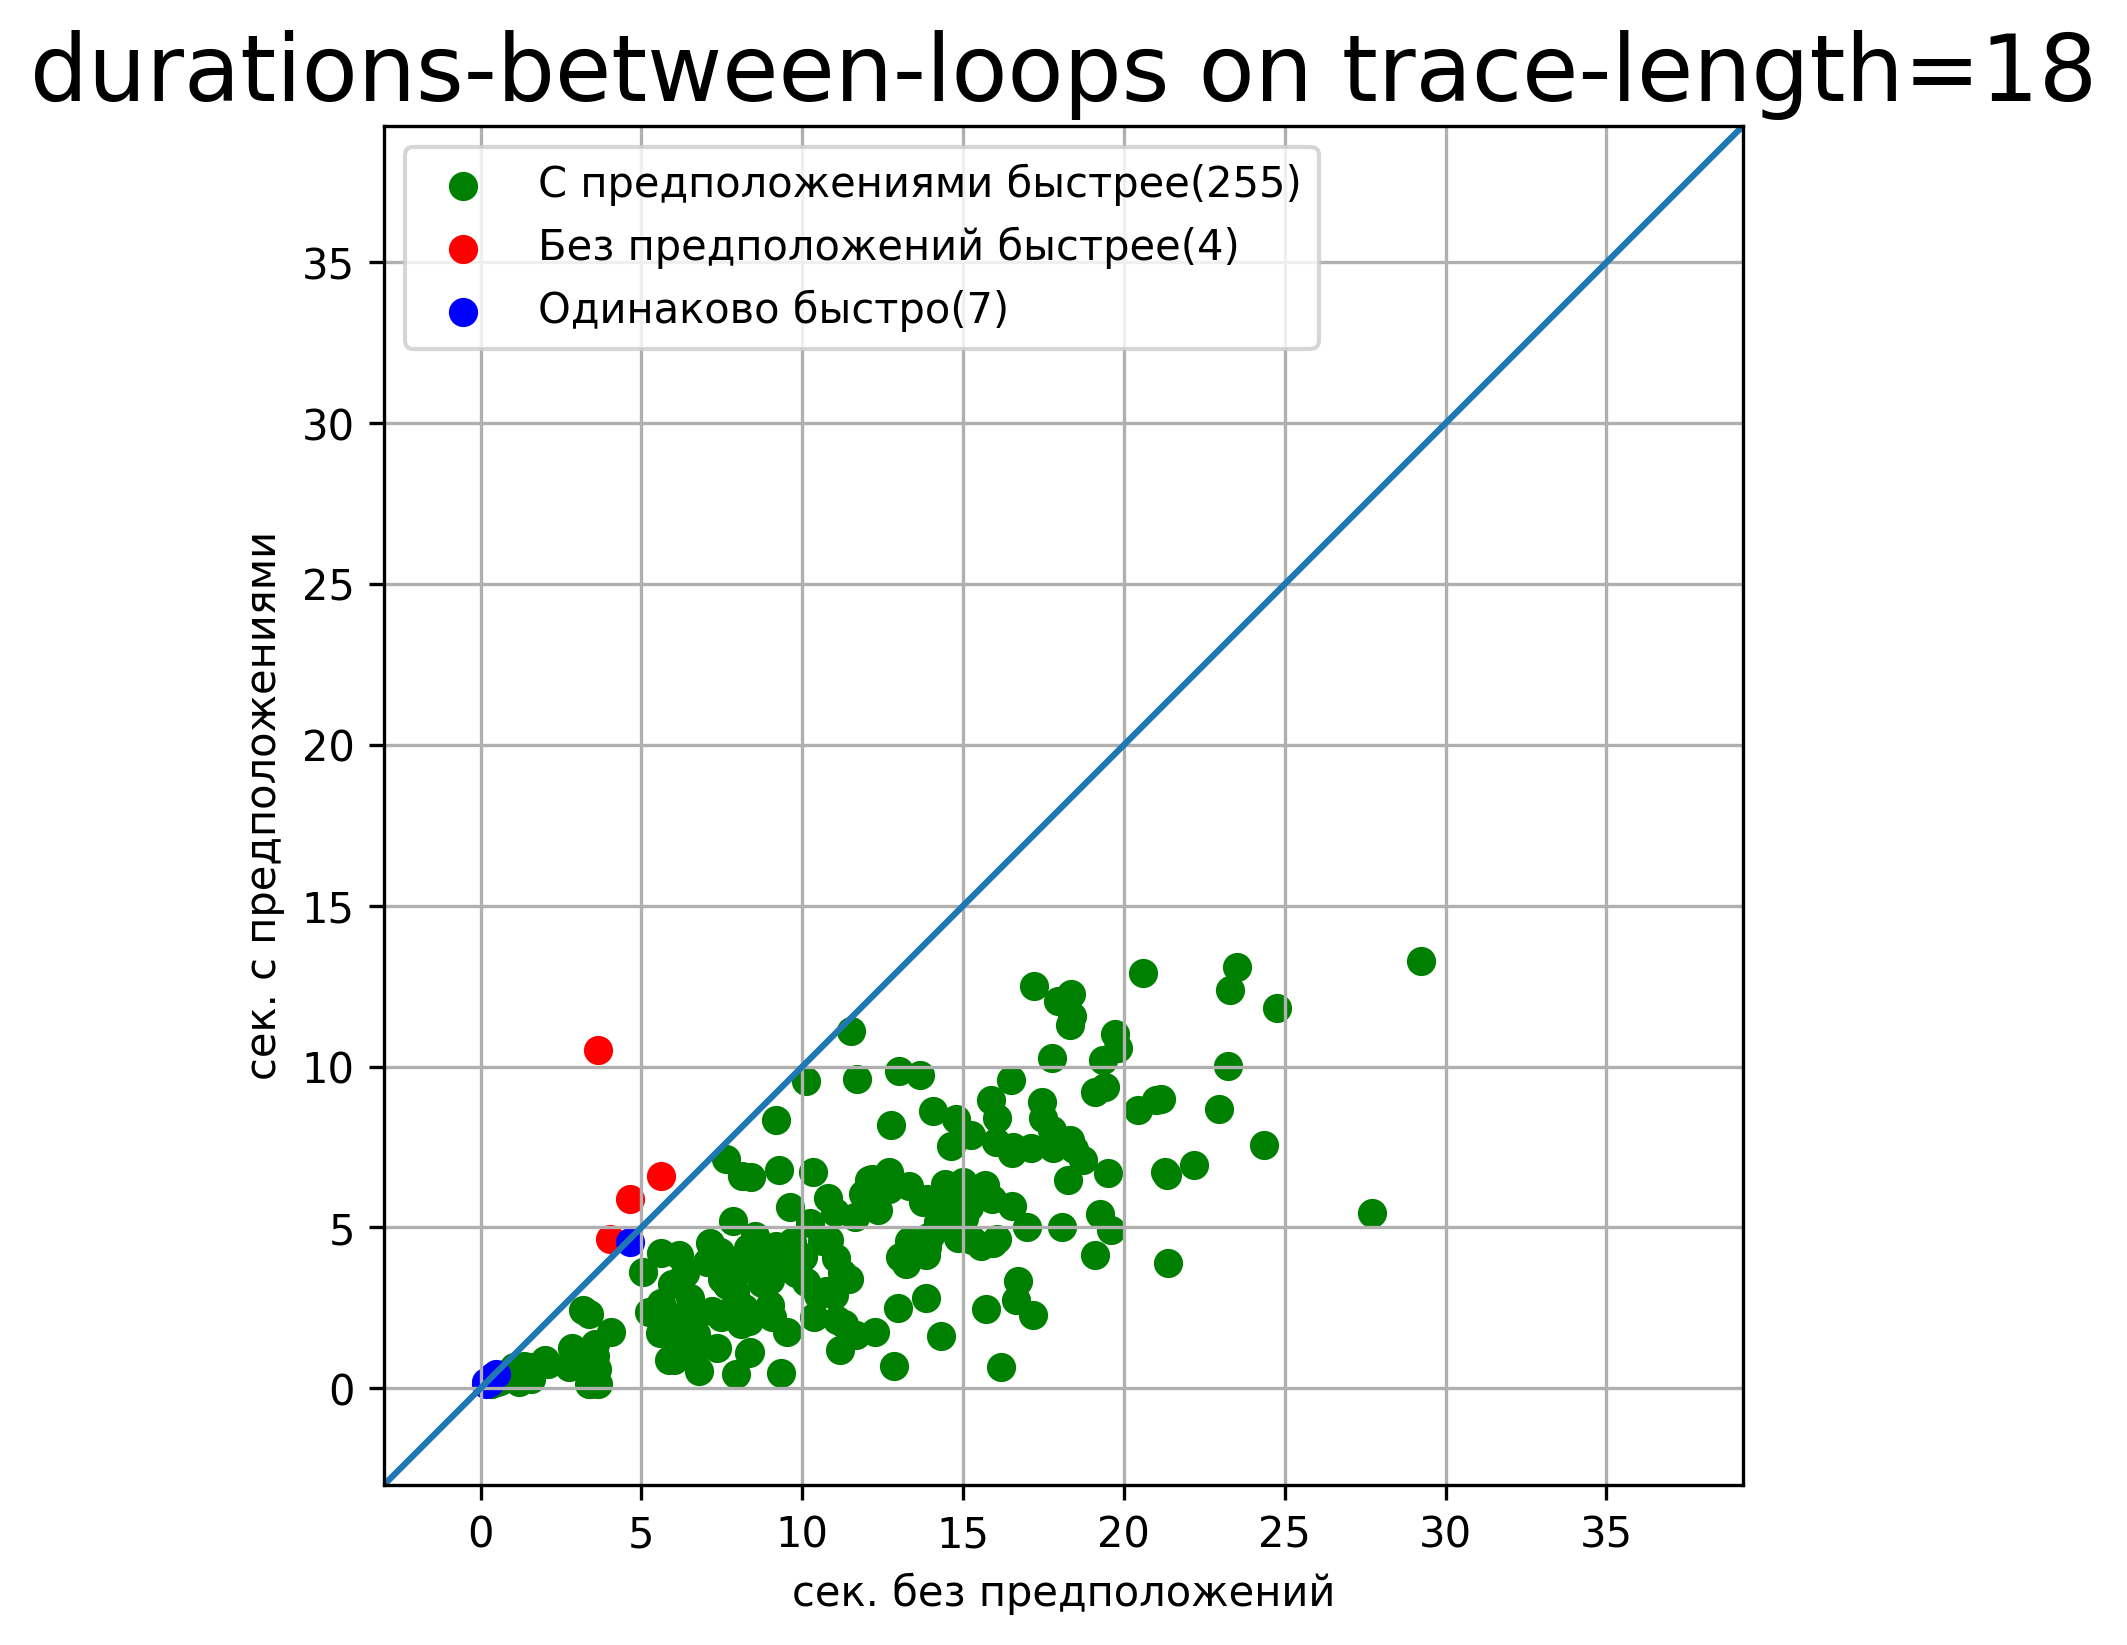

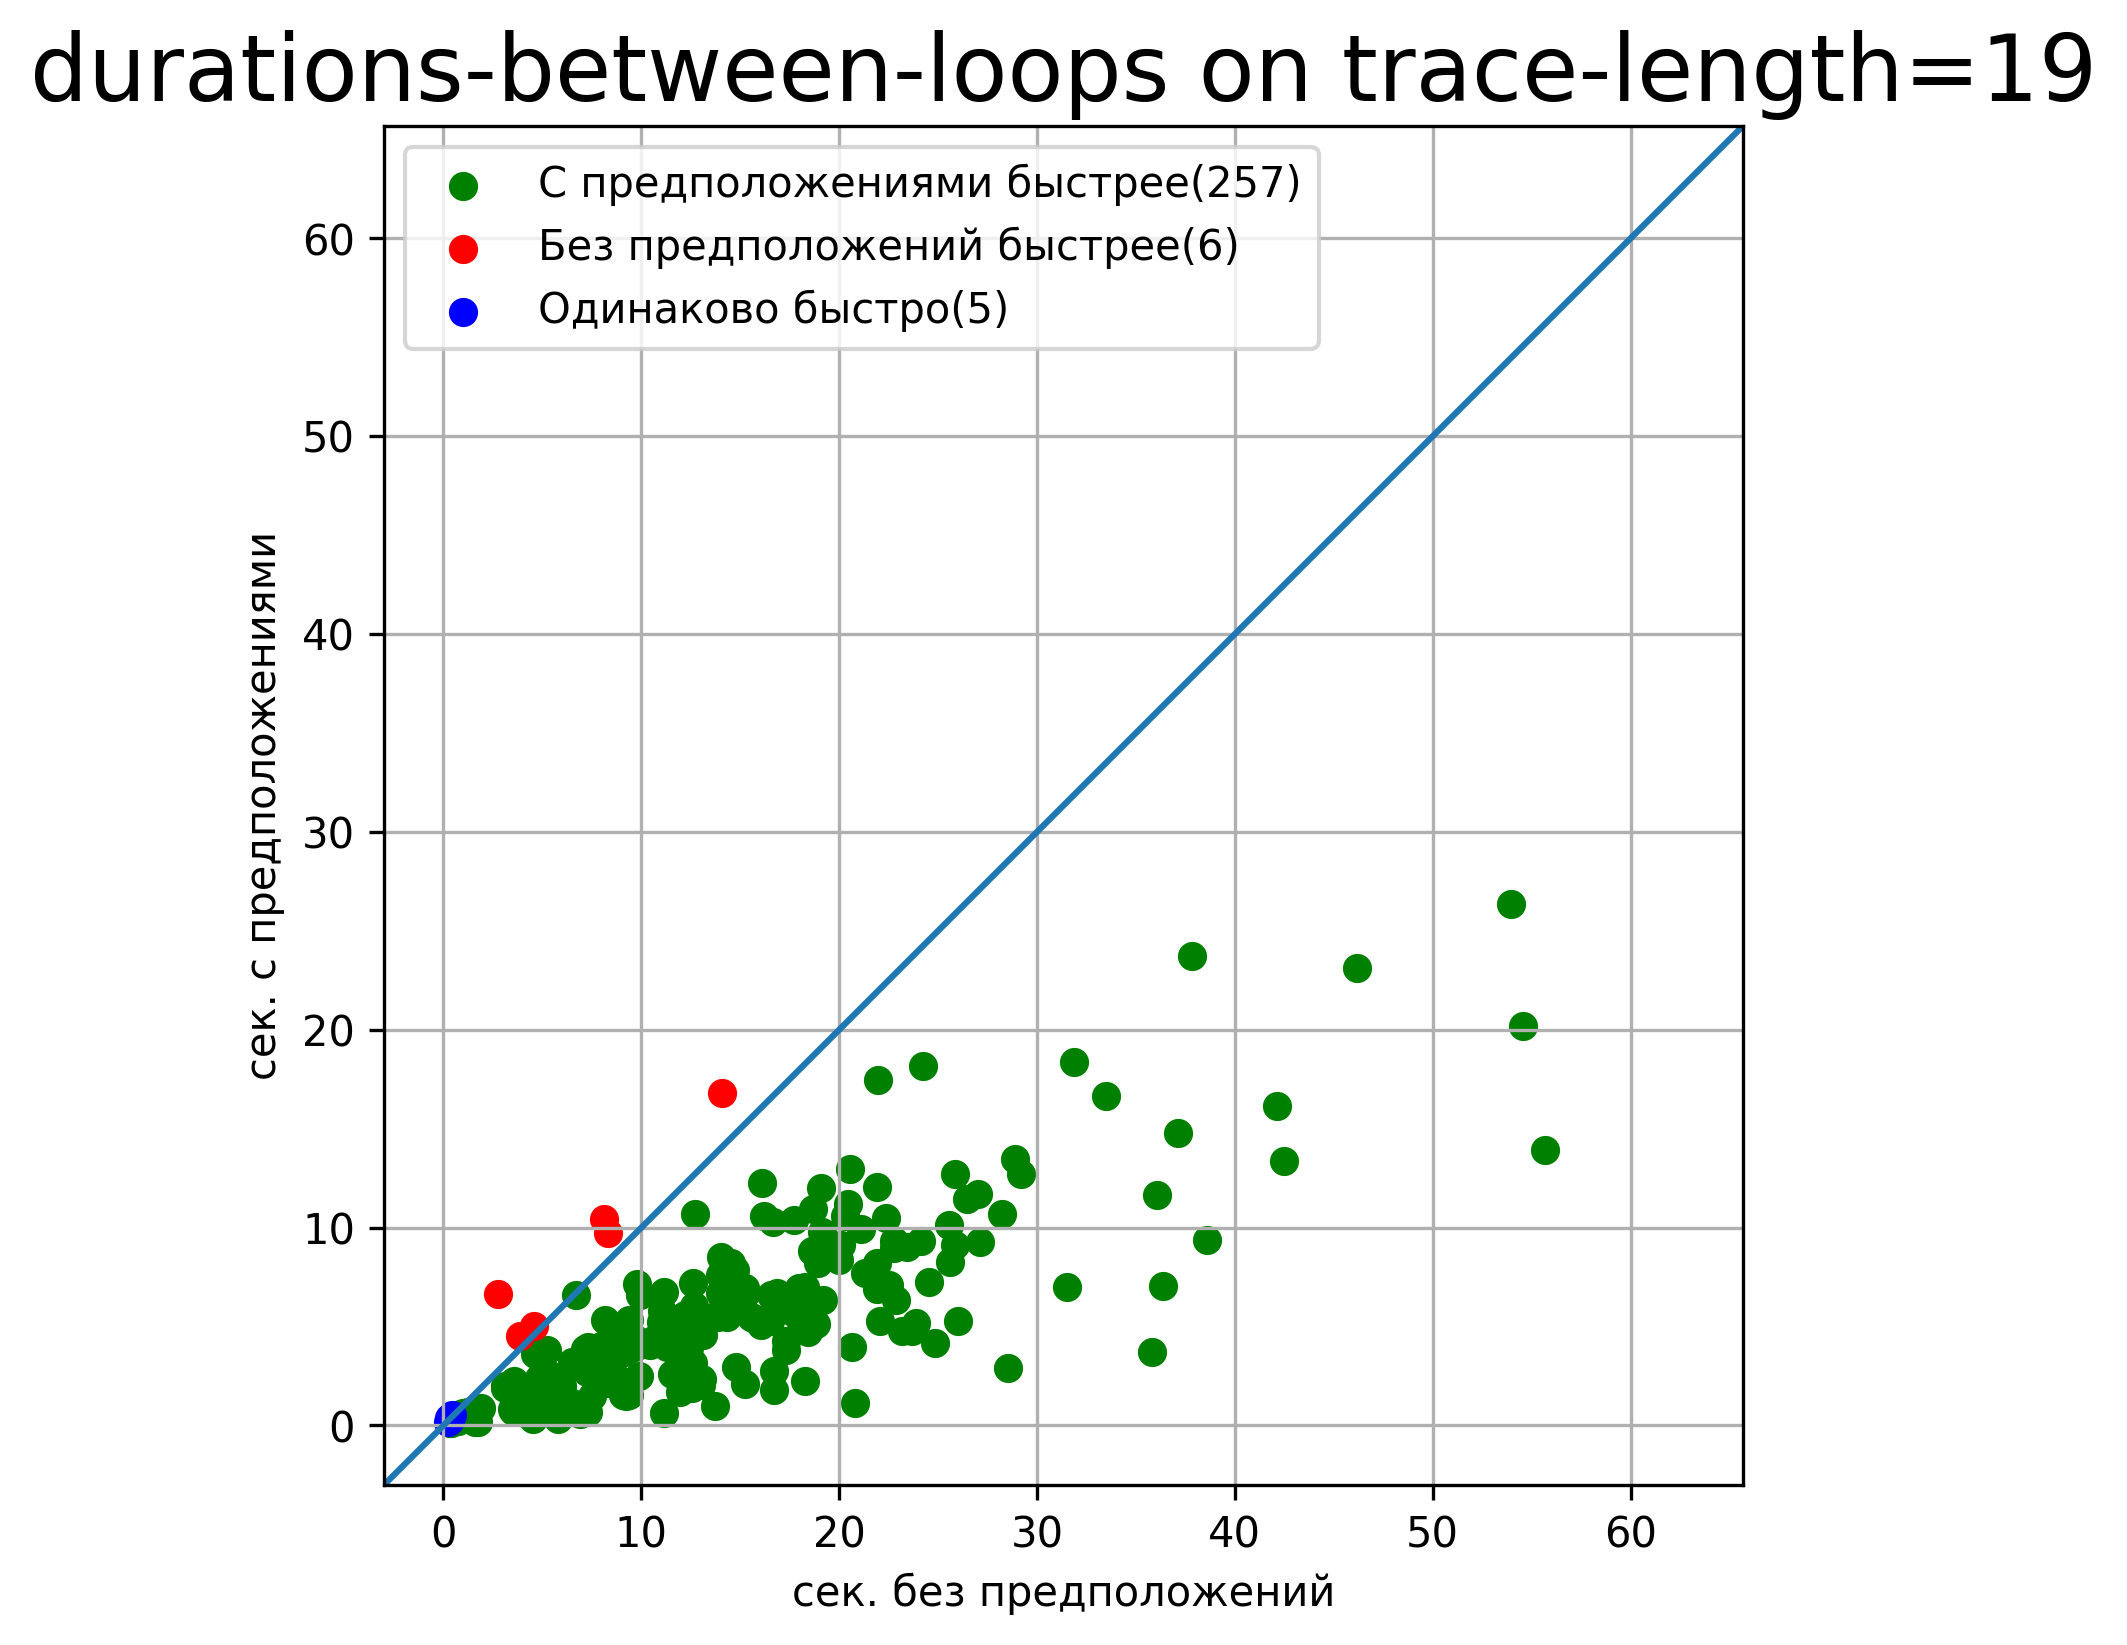

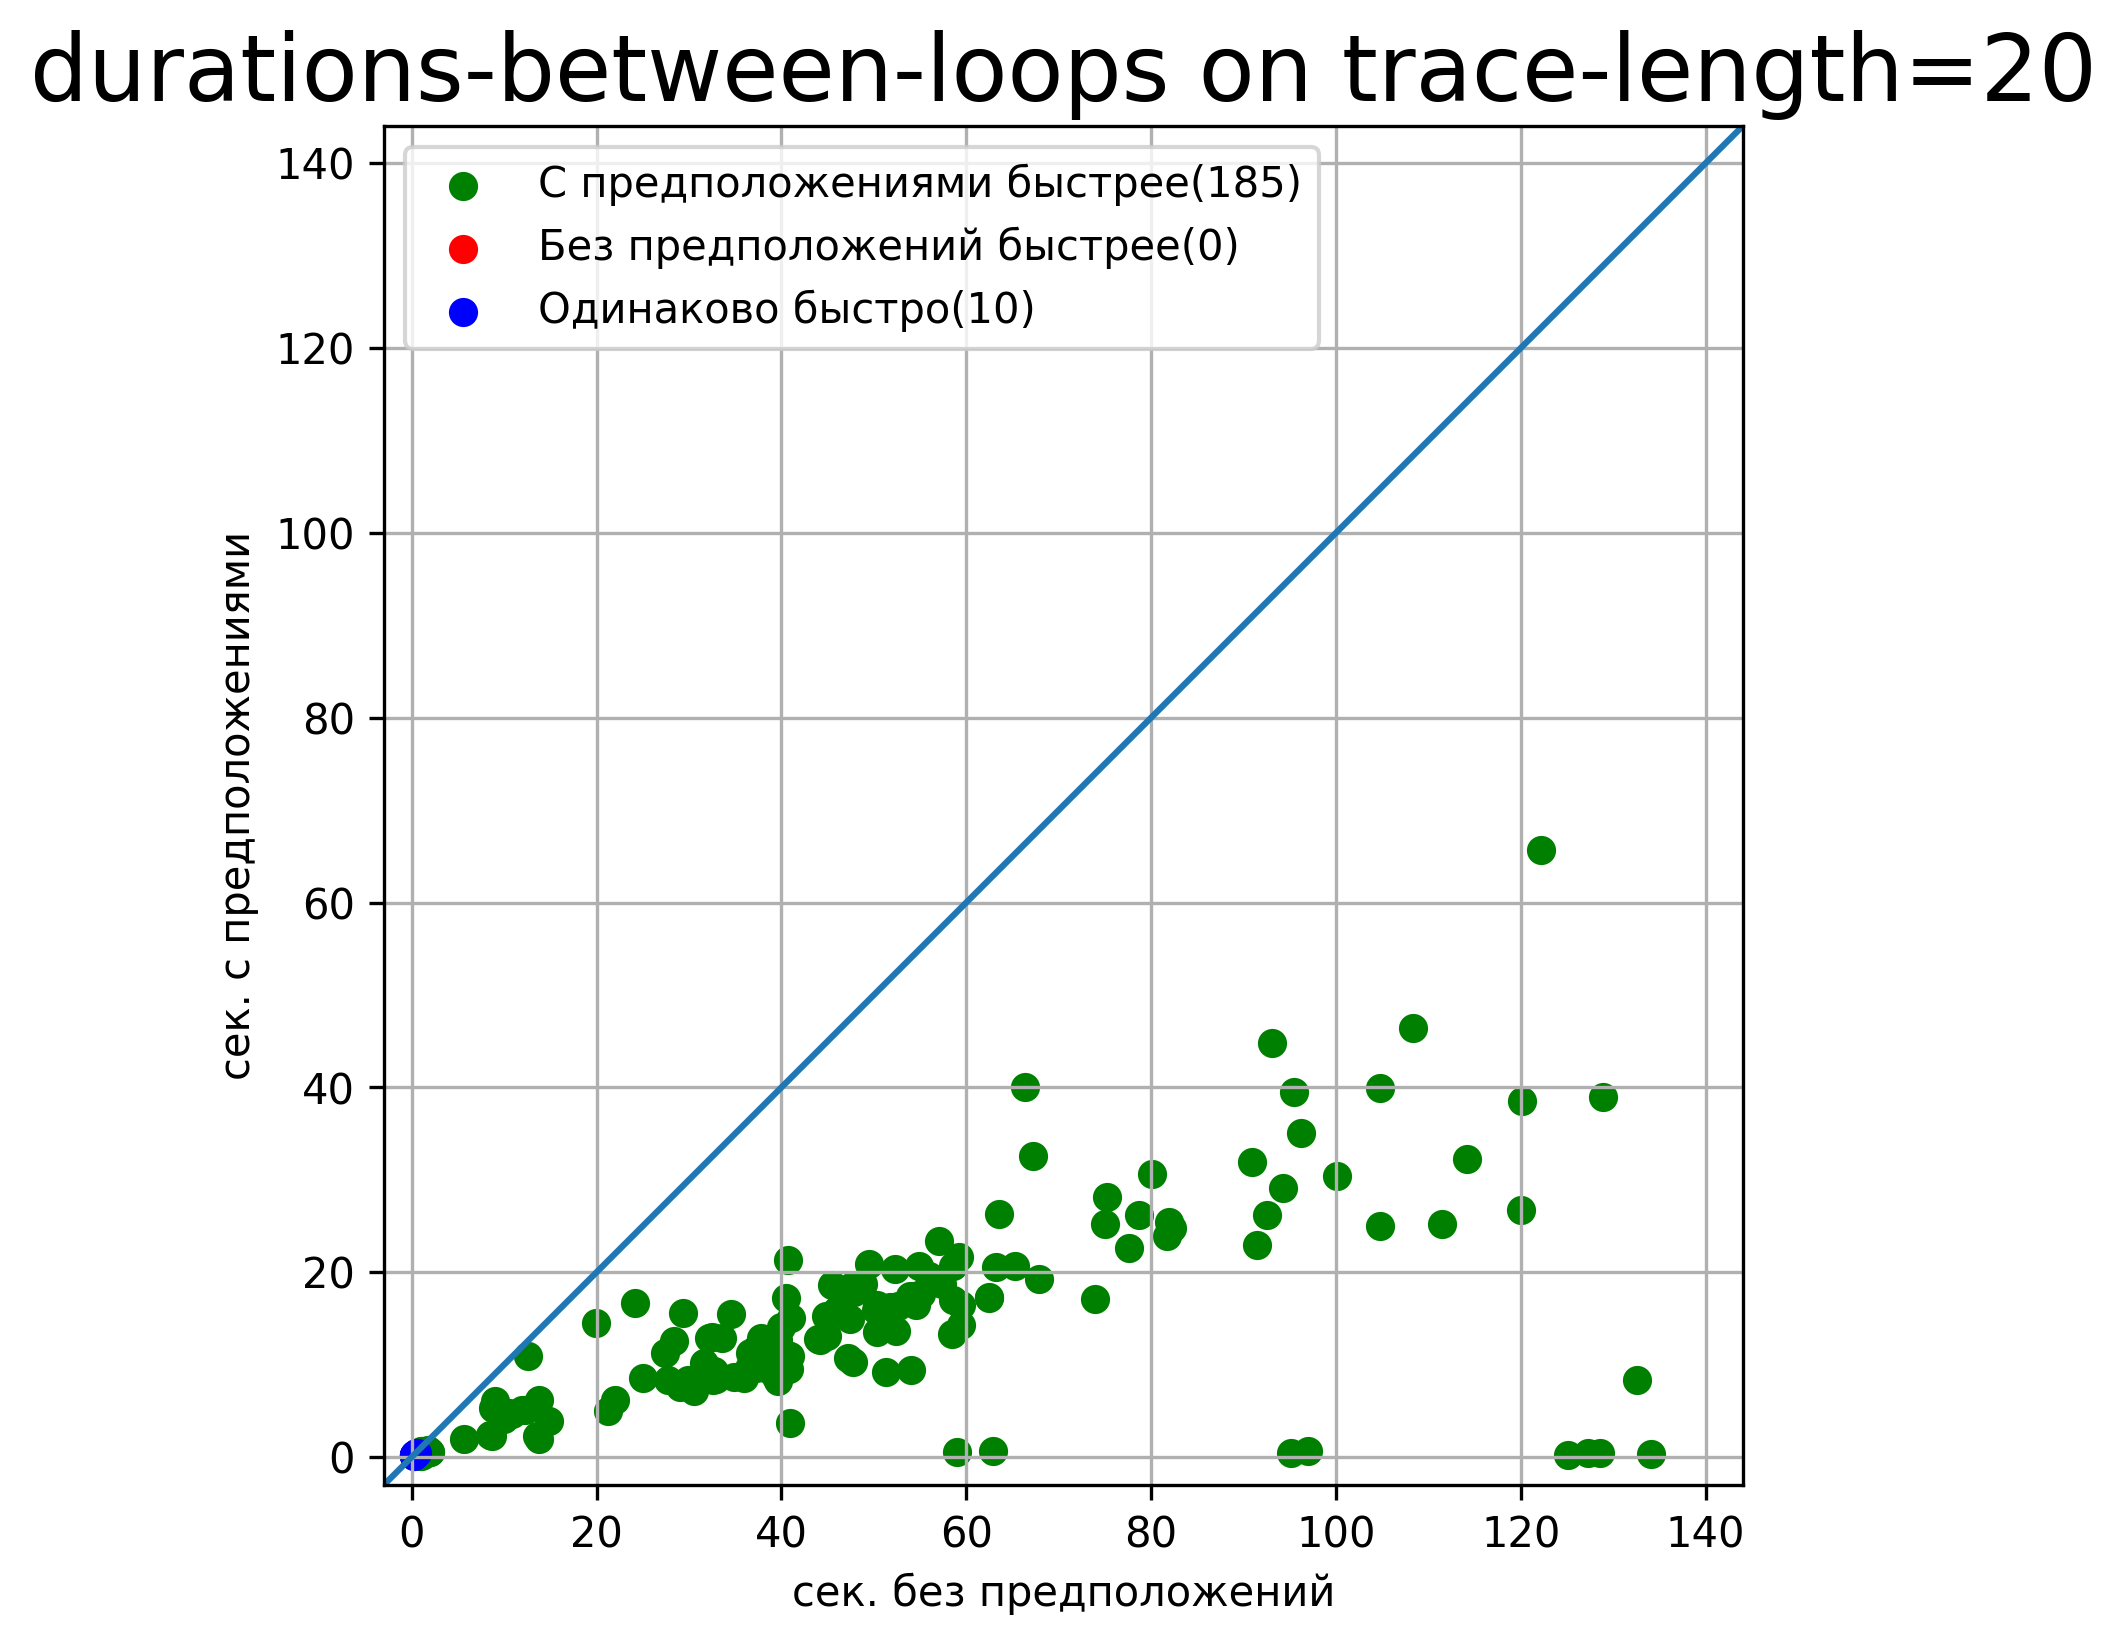

In [110]:
for i in range(18, 21):
    plt.figure(figsize=(8,6), dpi=300)
    info = extract_info(stats, [(1, {i}), (4, {'assumptions_between_loops_duration', 'general_between_loops_duration'})])
    keys = list({k[:4] + k[5:] for k in info if k[:4] + ('assumptions_between_loops_duration',) + k[5:] in info and k[:4] + ('general_between_loops_duration',) + k[5:] in info})
    y = [info[k[:4] + ('assumptions_between_loops_duration',) + k[4:]] for k in keys]
    x = [info[k[:4] + ('general_between_loops_duration'    ,) + k[4:]] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y, 0)
    
    plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    plt.scatter(x_blue, y_blue, color='blue', label=f'Время различается менее чем на 0.1с({len(x_blue)})')
    #plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    mx = max(max(x), max(y))
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')
    
    plt.title(f'durations-between-loops on trace-length={i}', fontsize=22)
    plt.xlabel('сек. без предположений')
    plt.ylabel('сек. с предположениями')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()


<ipython-input-113-432e79feebc8>:16: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


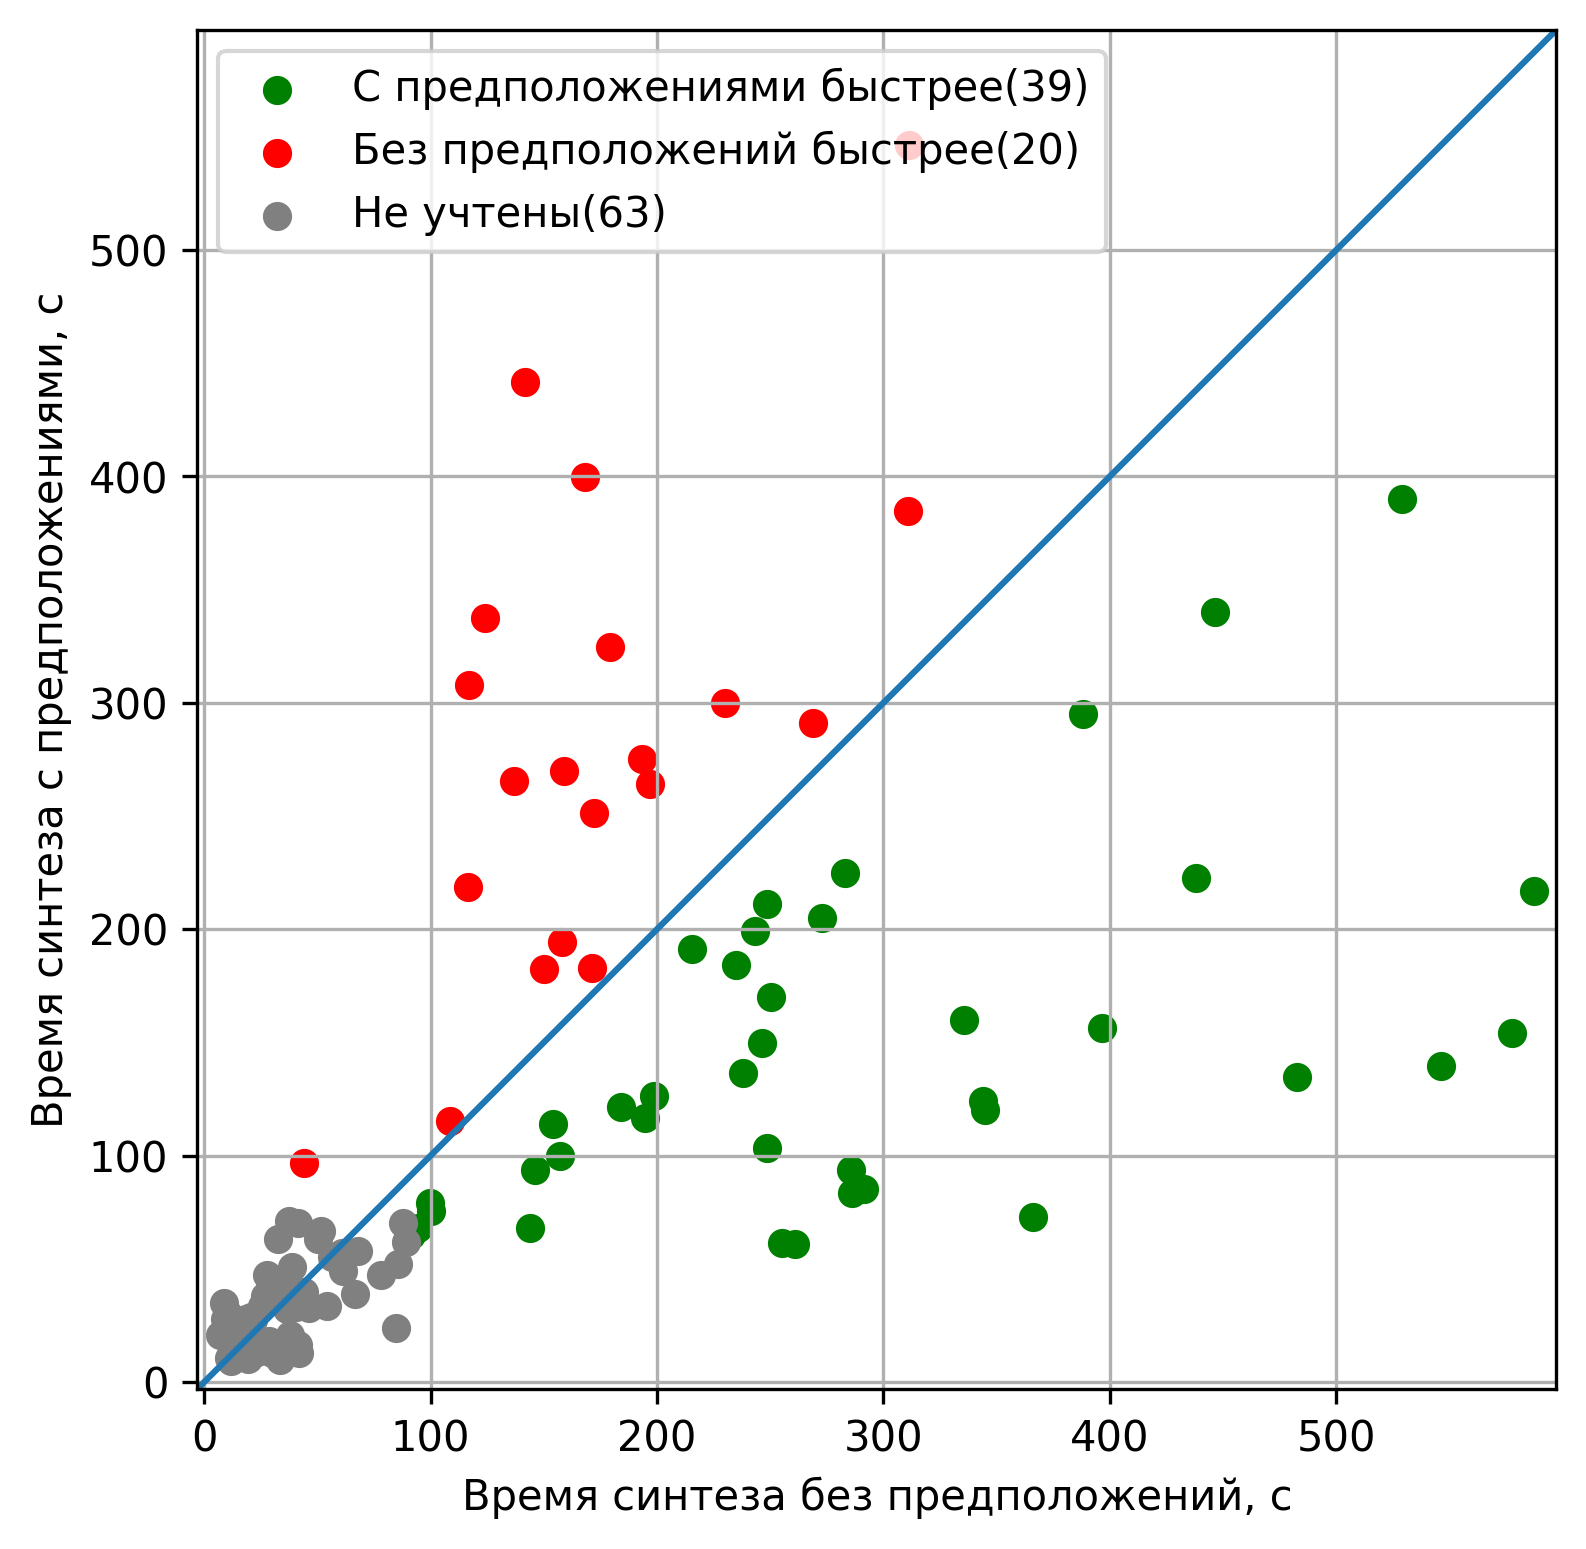

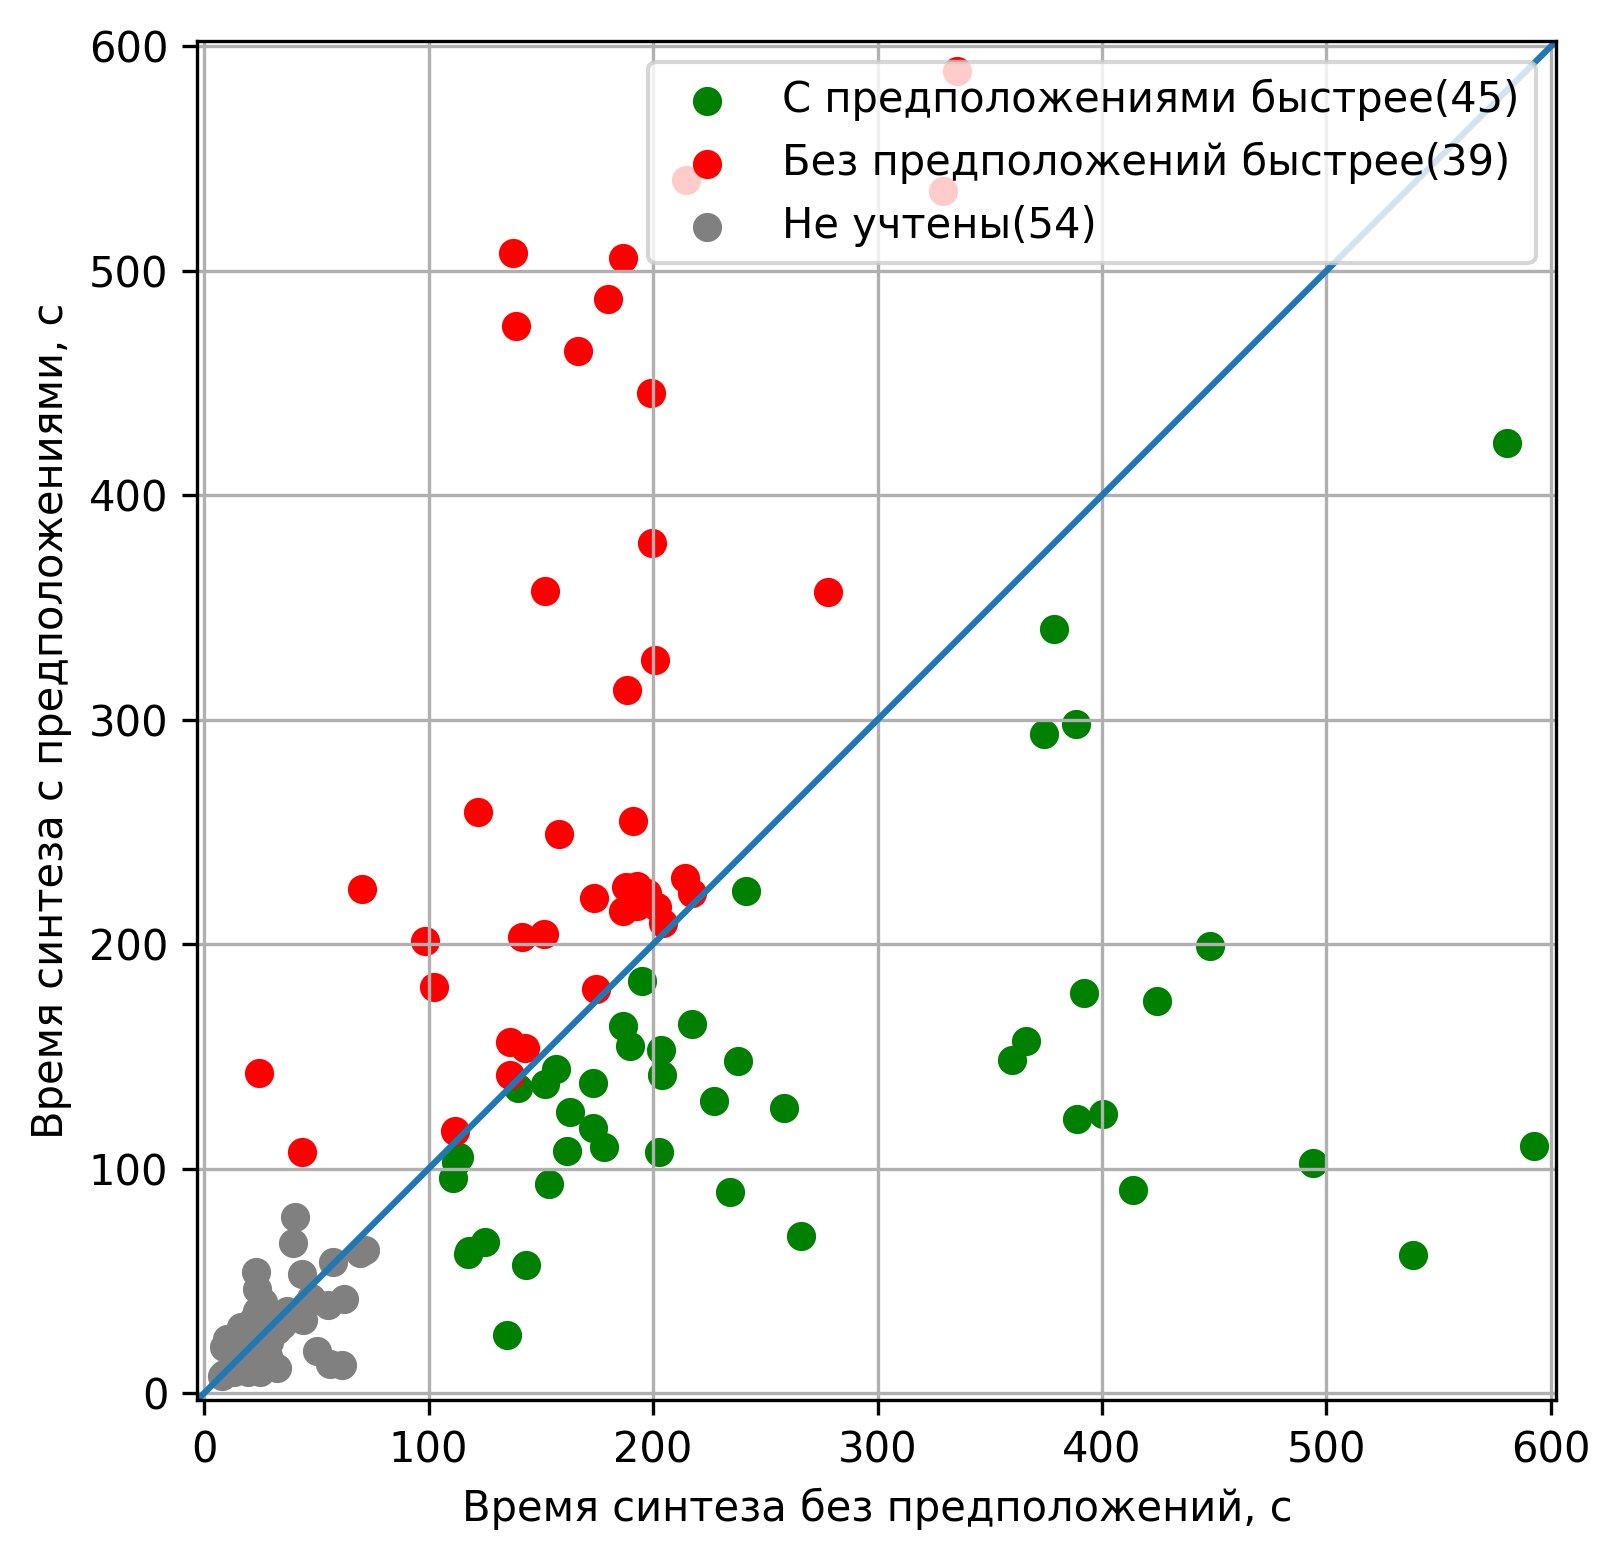

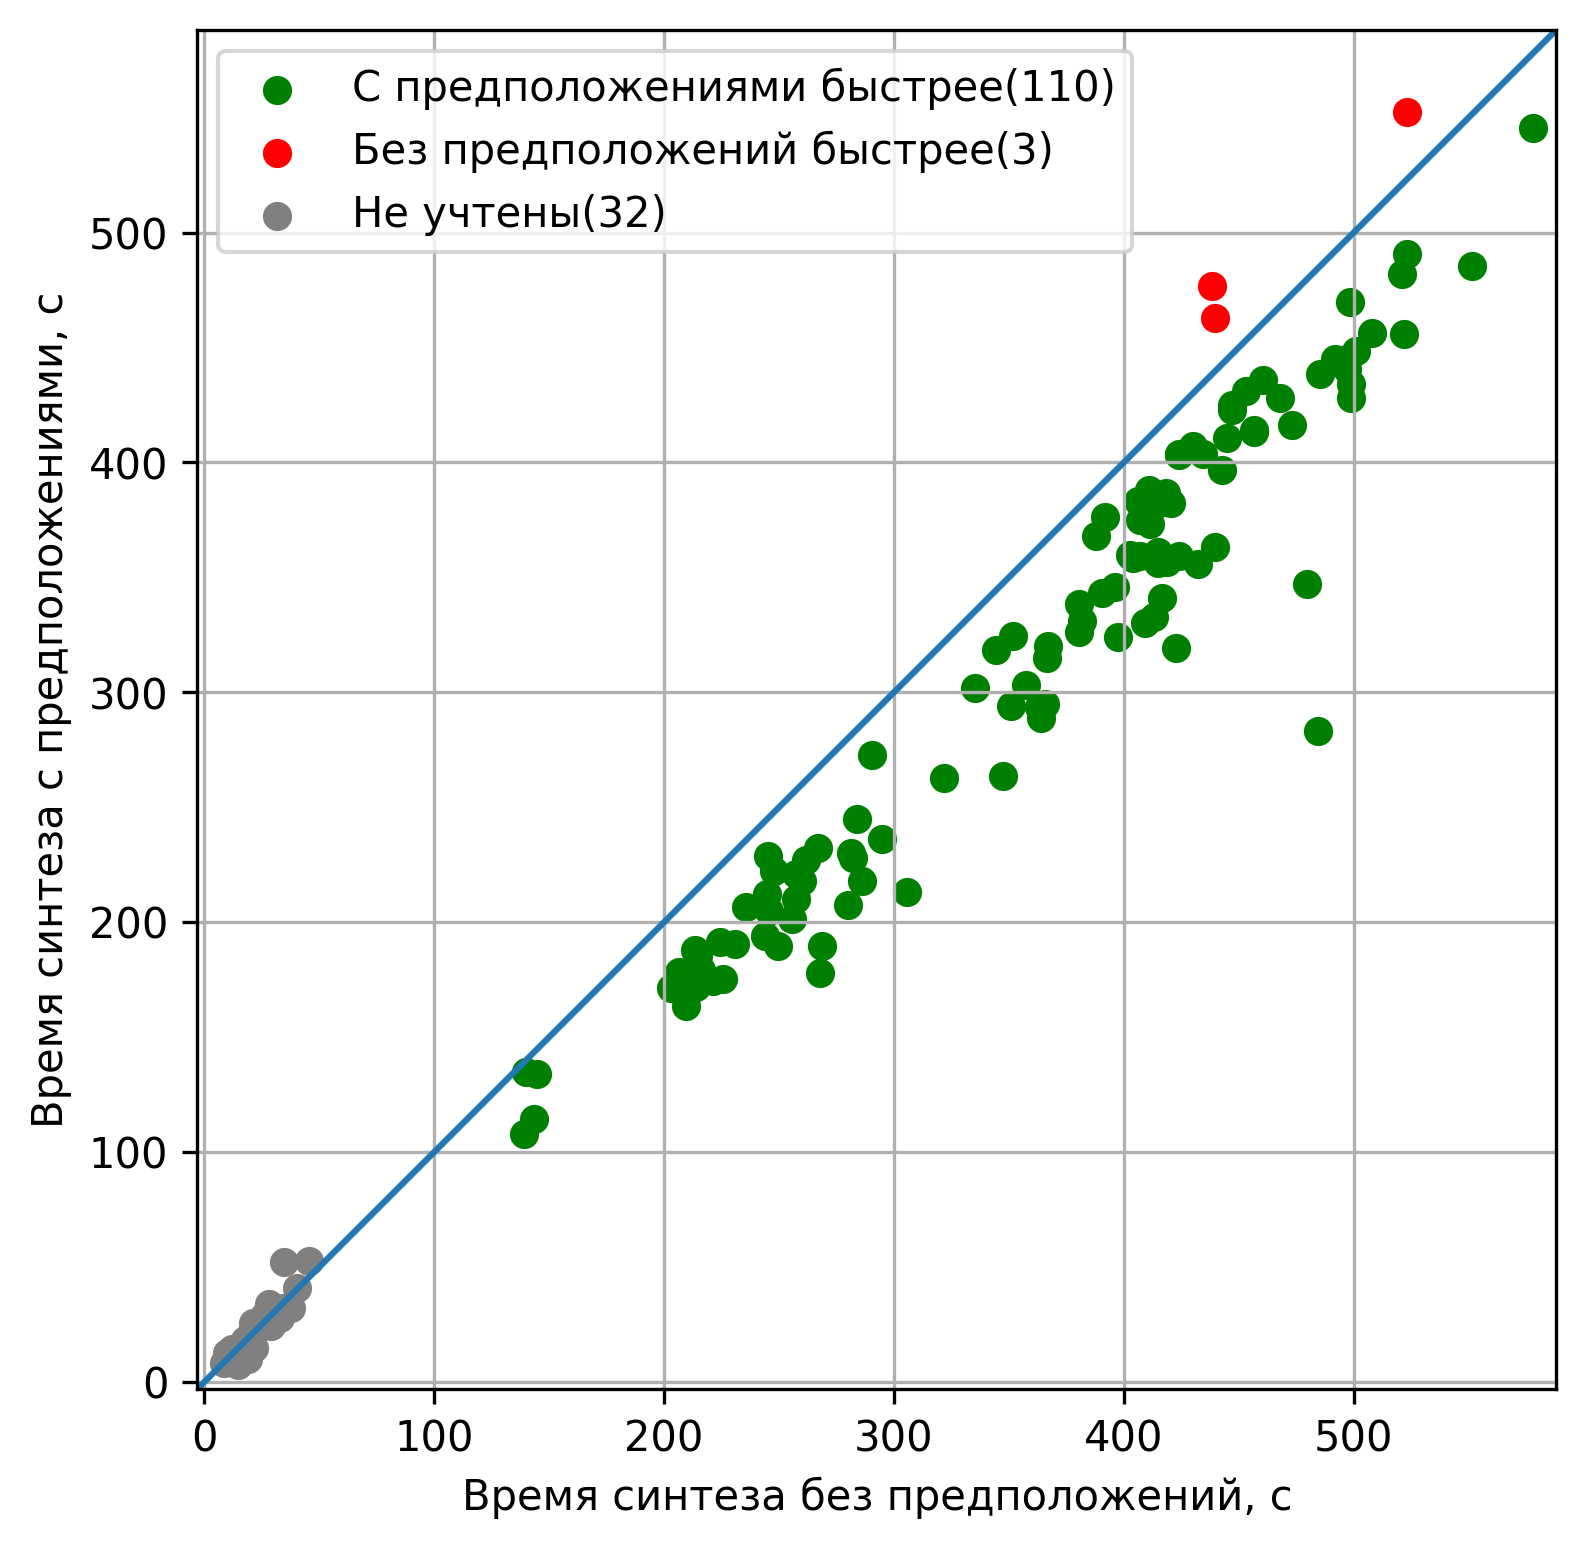

In [113]:
for i in range(18, 21):
    plt.figure(figsize=(8,6), dpi= 300)

    info = extract_info(stats, [(1, {i}), (4, {'assumptions_total_duration', 'general_total_duration'})])
    keys = list({k[:4] for k in info if info[k[:4] + ('assumptions_total_duration',)] is not None and info[k[:4] + ('general_total_duration',)] is not None})
    y = [info[k[:4] + ('assumptions_total_duration',)] for k in keys]
    x = [info[k[:4] + ('general_total_duration'    ,)] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y)

    plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    #plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
    plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    mx = max(max(x), max(y))
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

#    plt.title(f'Время синтеза с длиной трассировки {i}', fontsize=20)
    plt.xlabel('Время синтеза без предположений, с')
    plt.ylabel('Время синтеза с предположениями, с')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()

<ipython-input-112-75409d66efde>:16: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


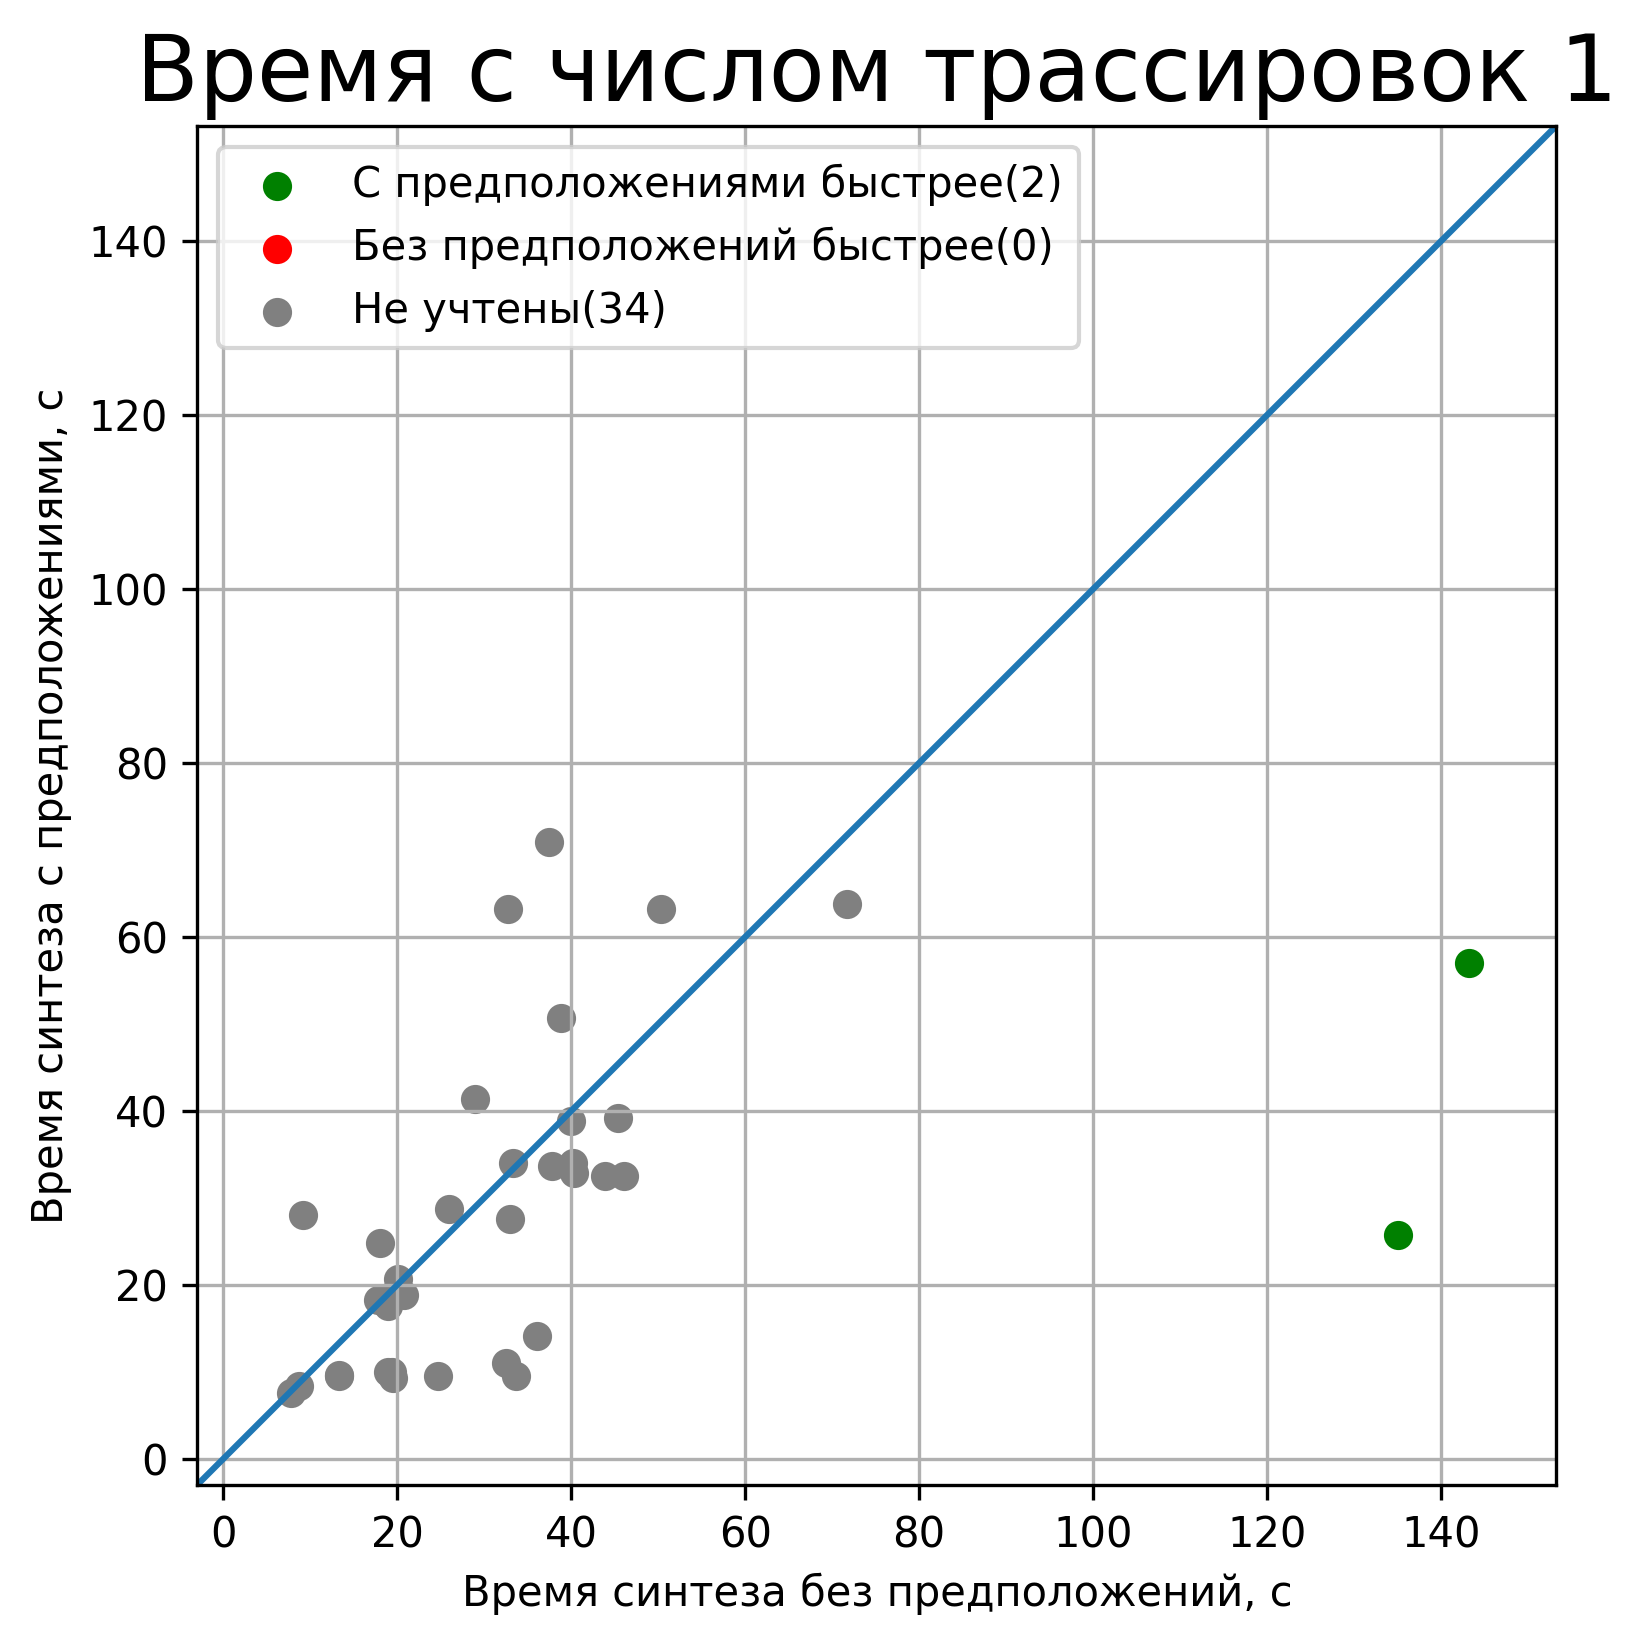

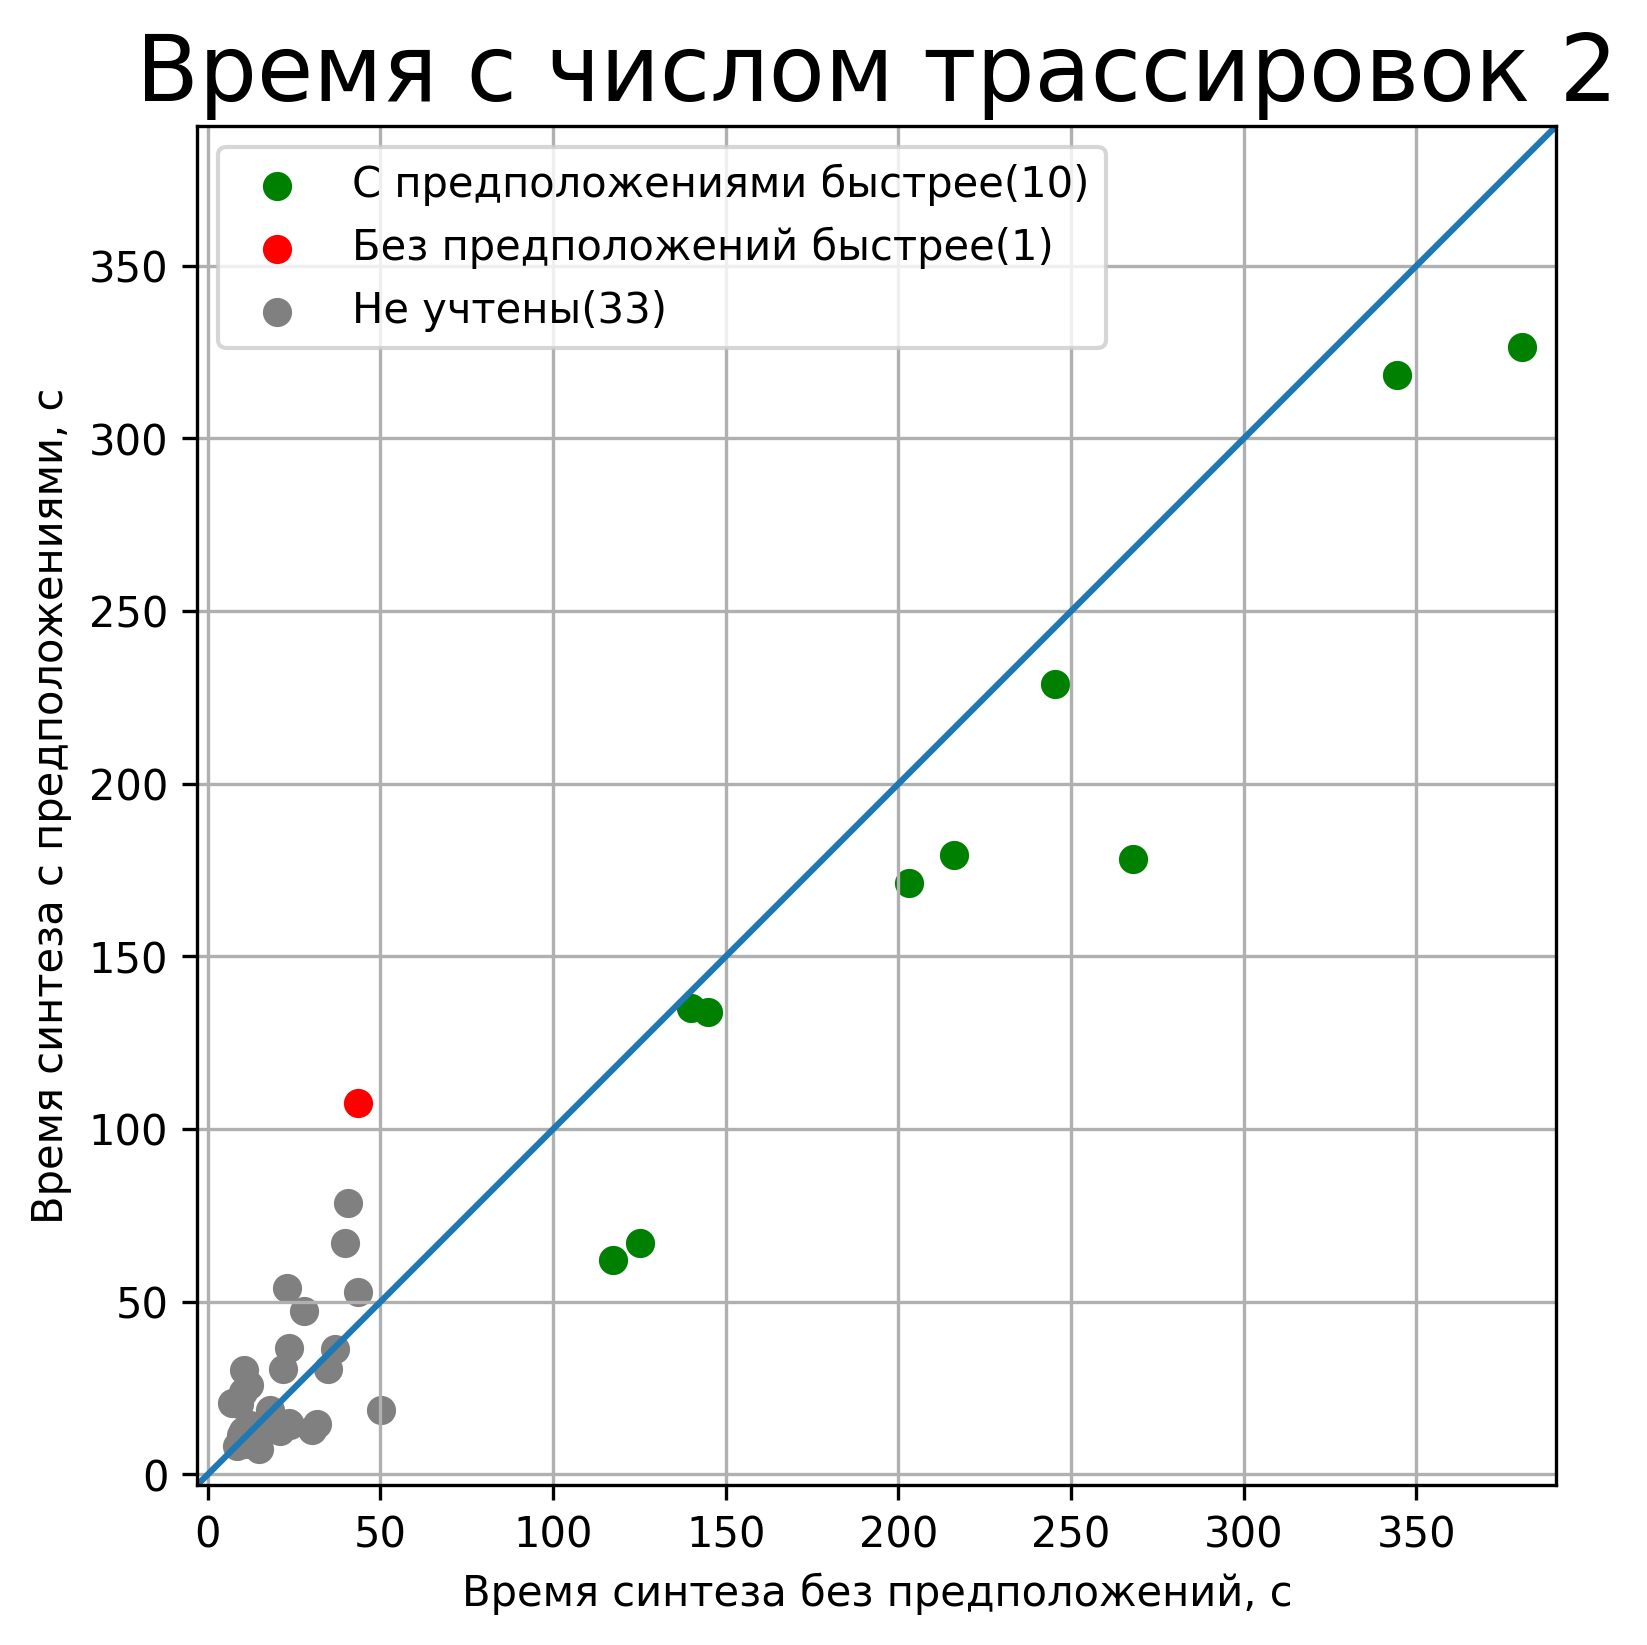

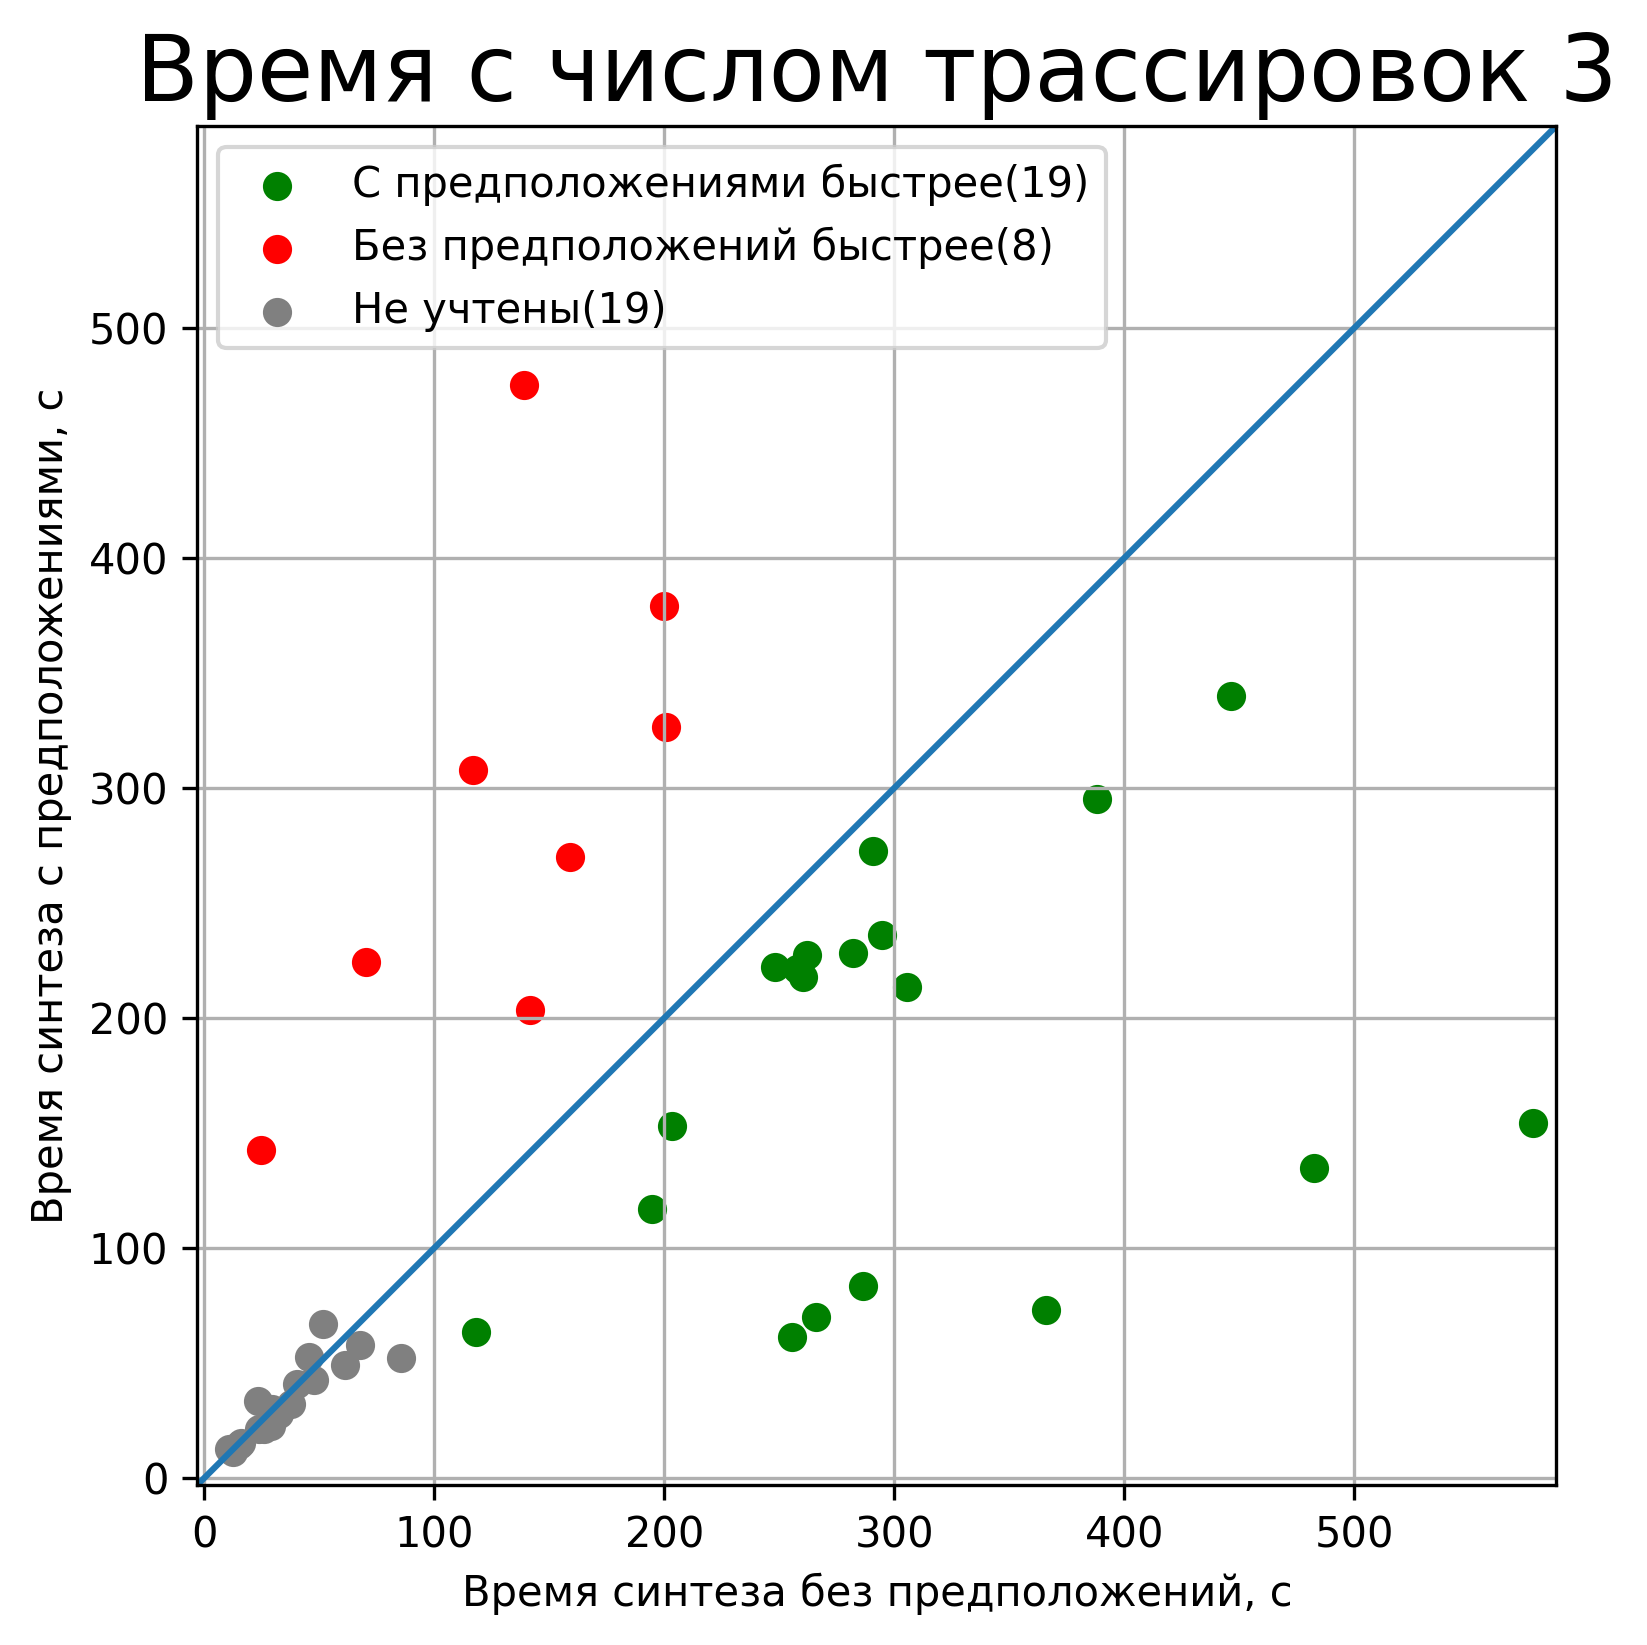

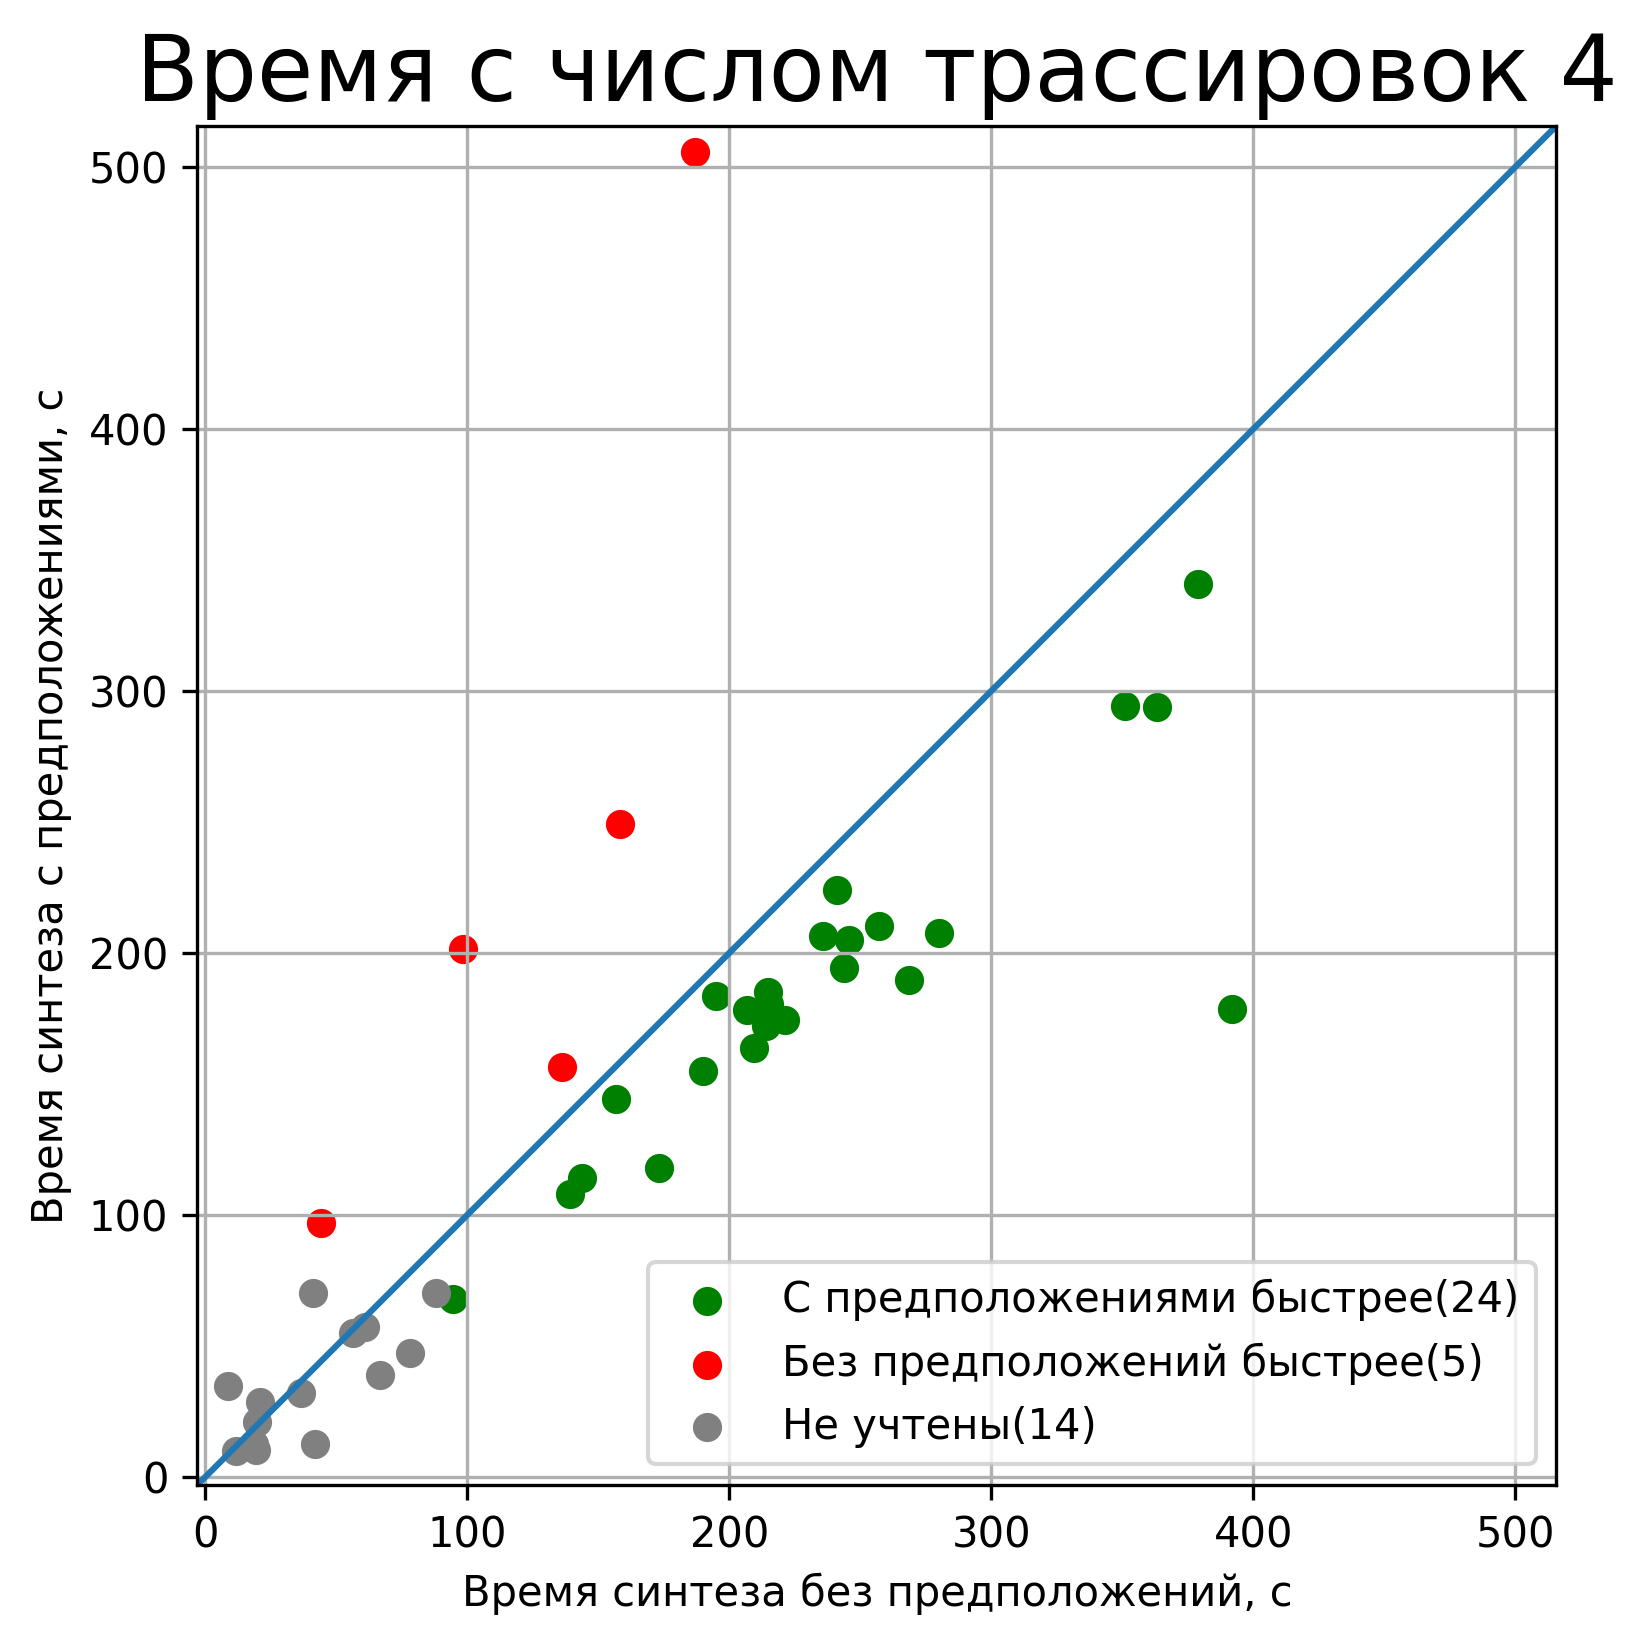

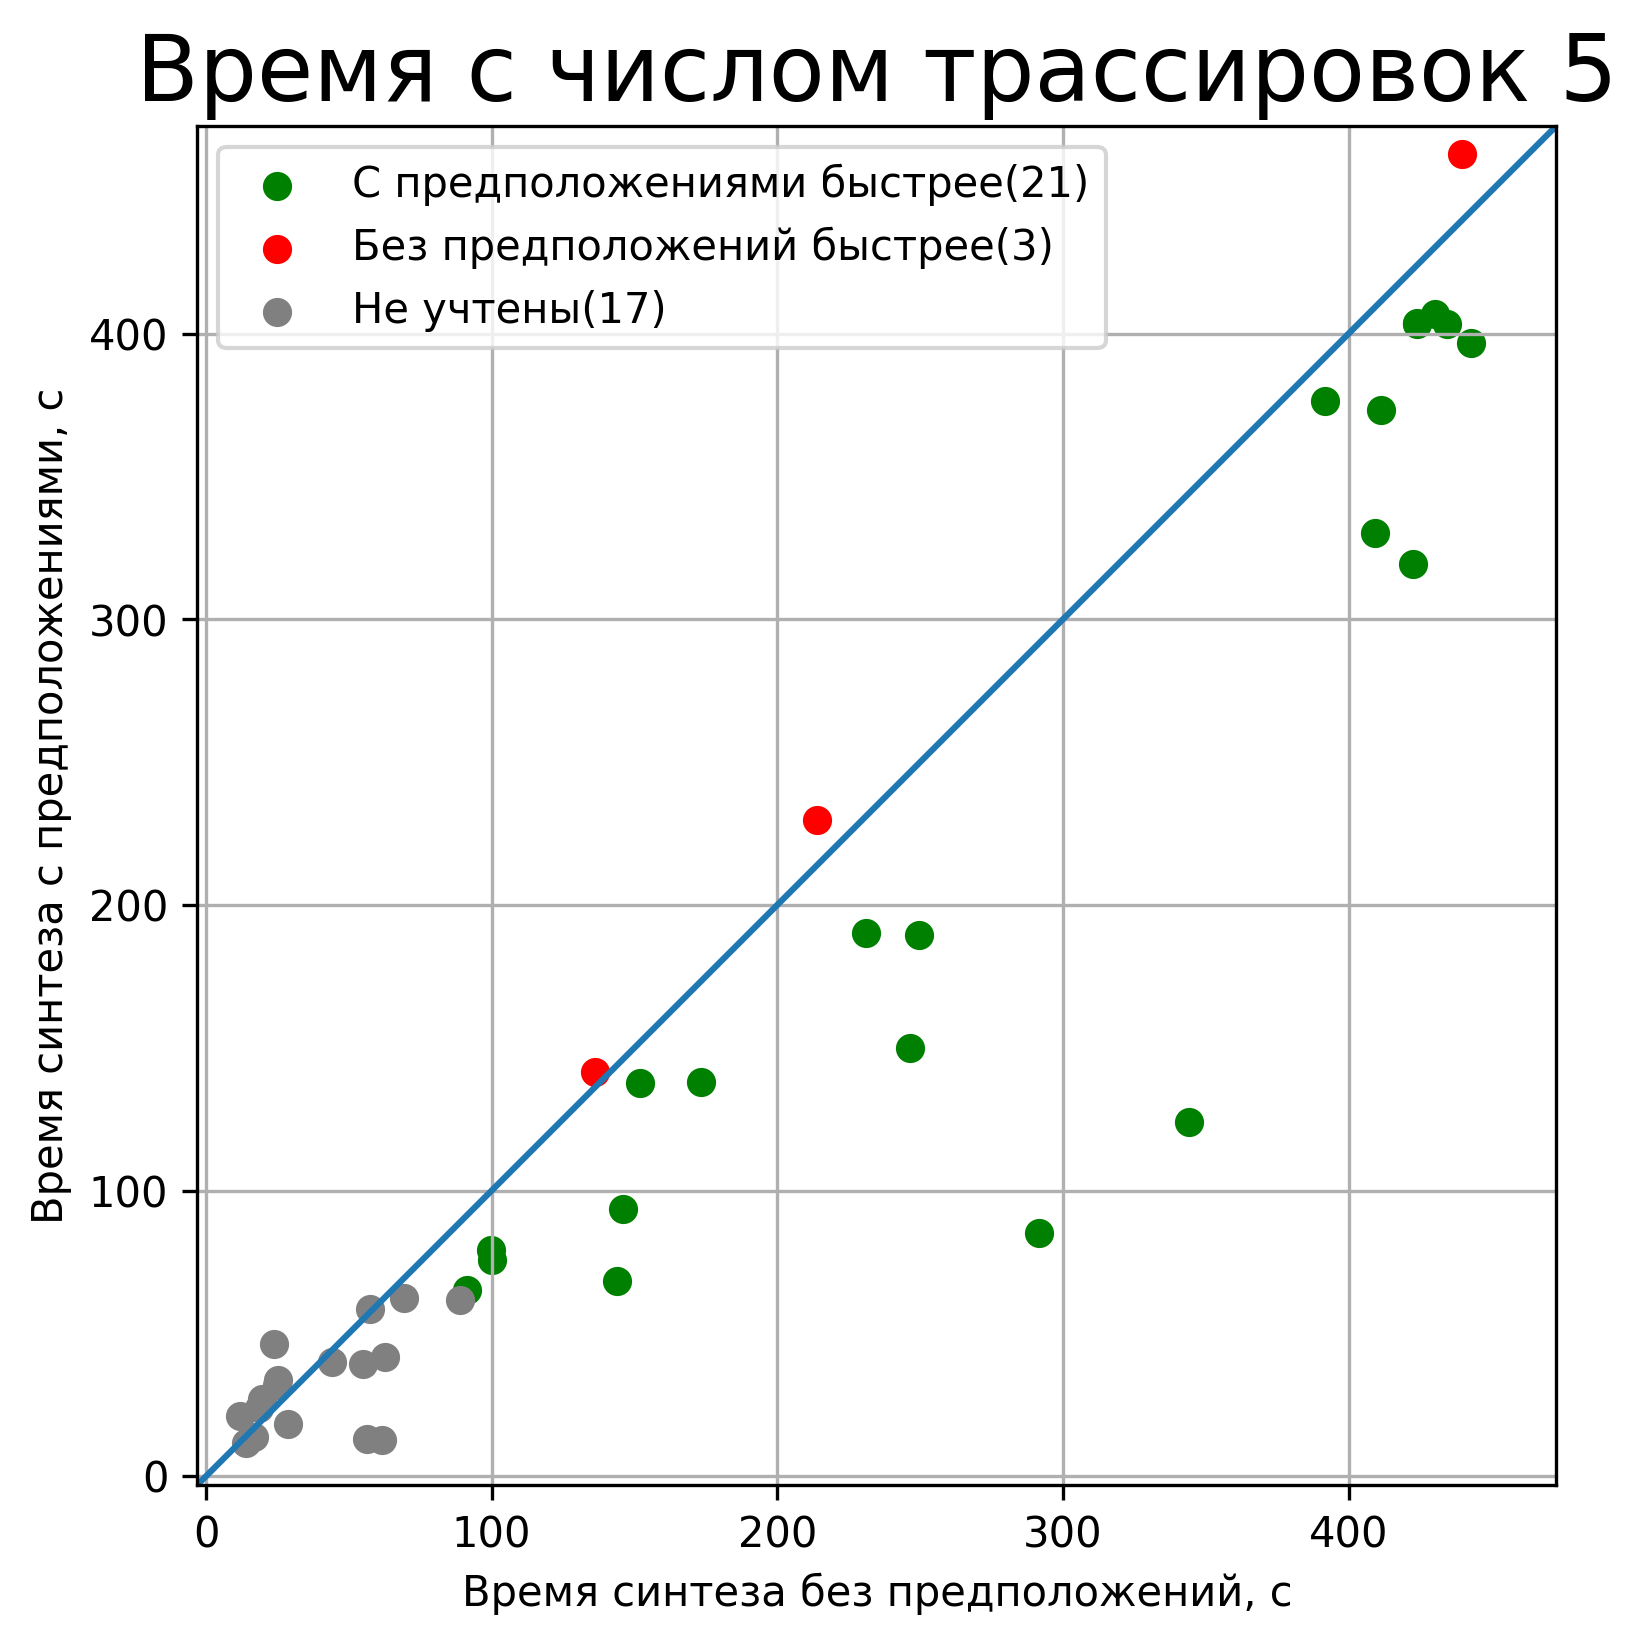

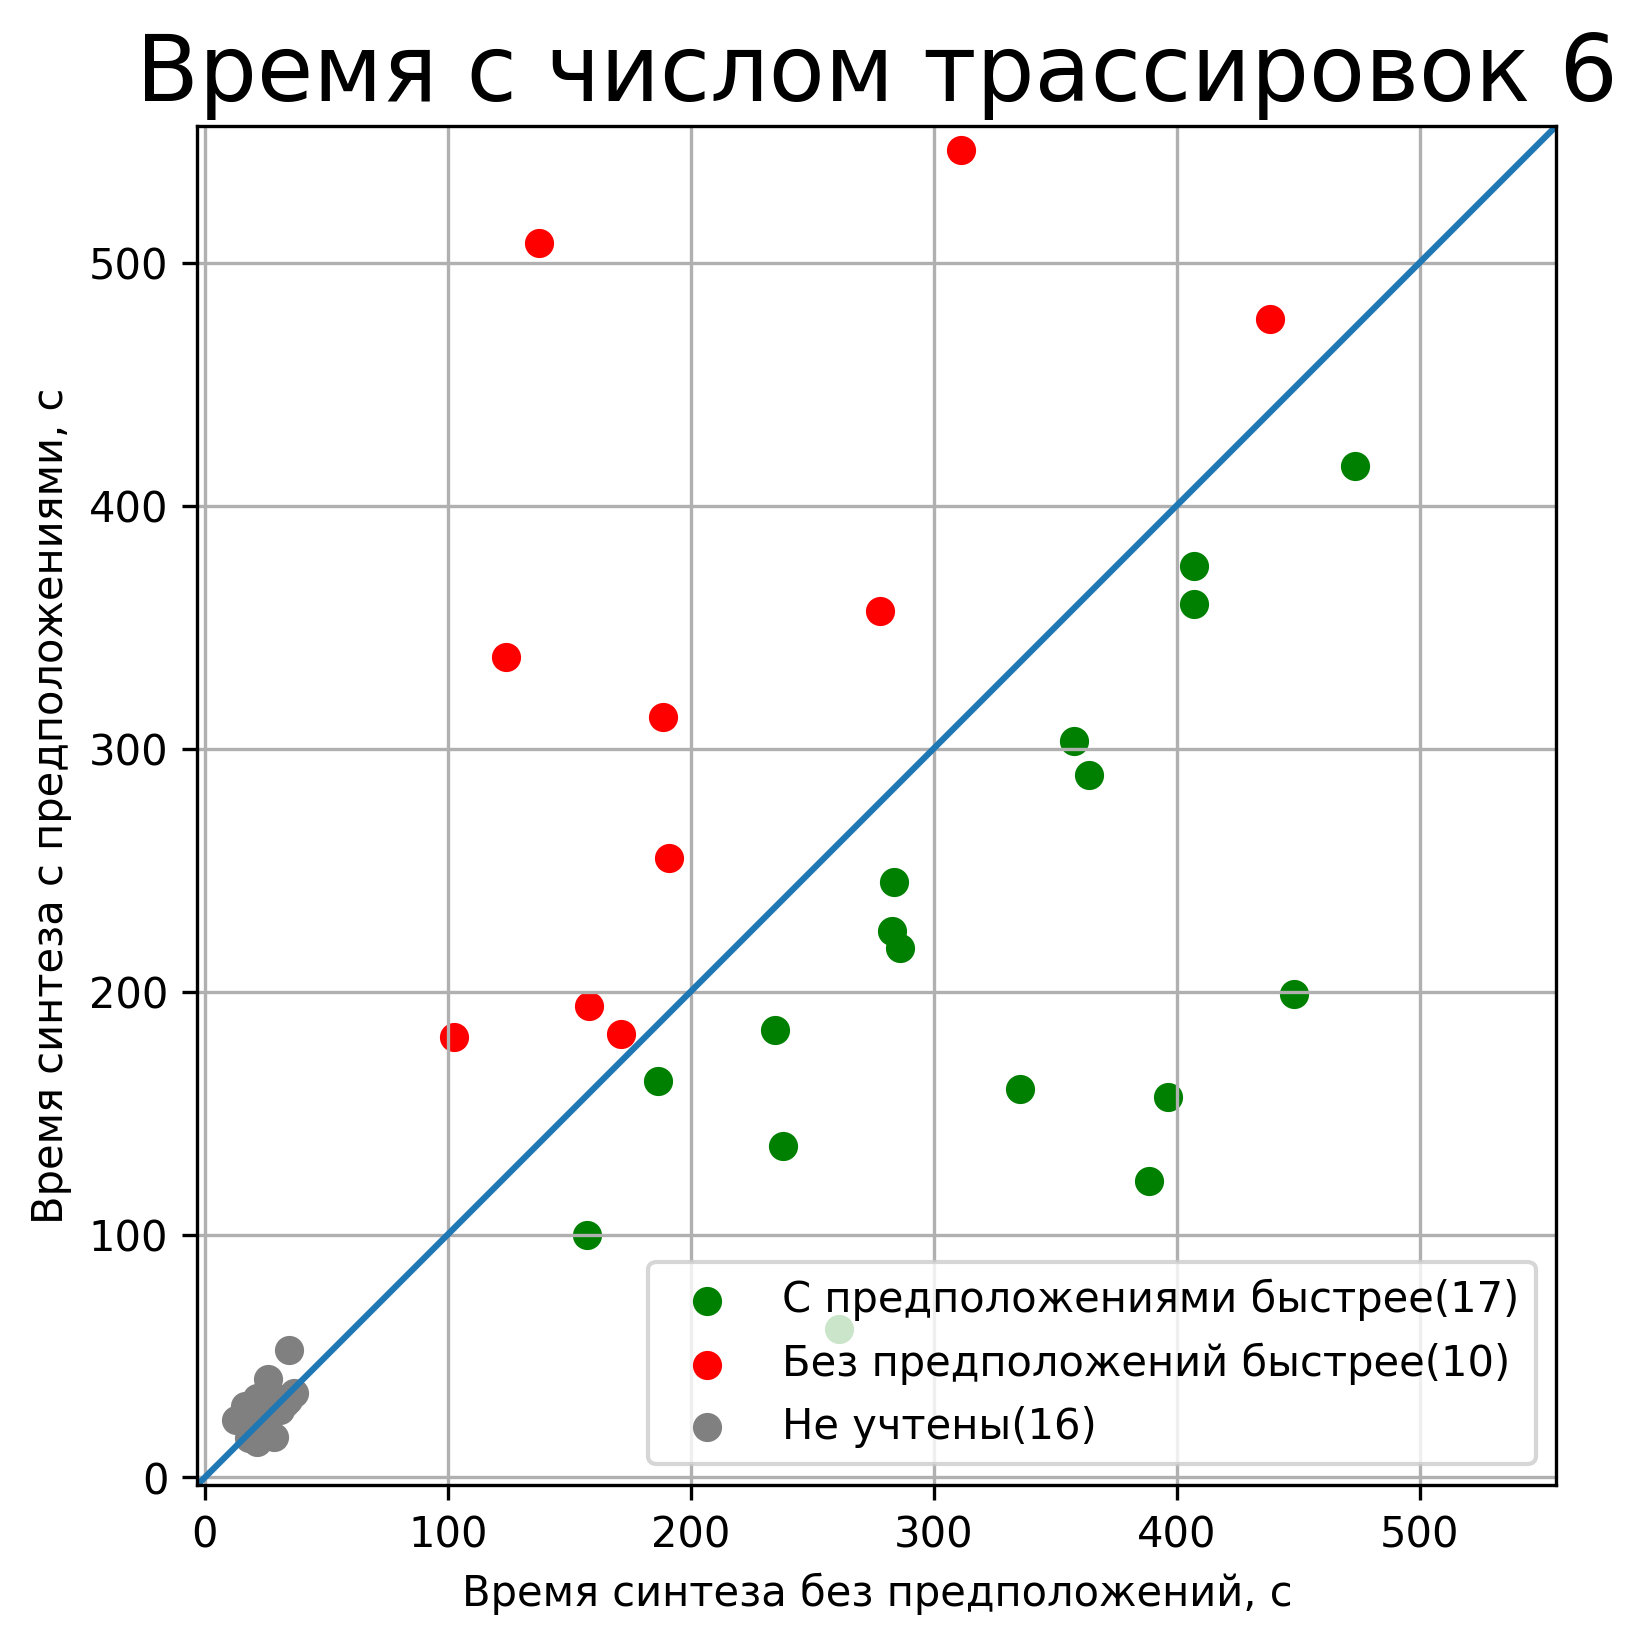

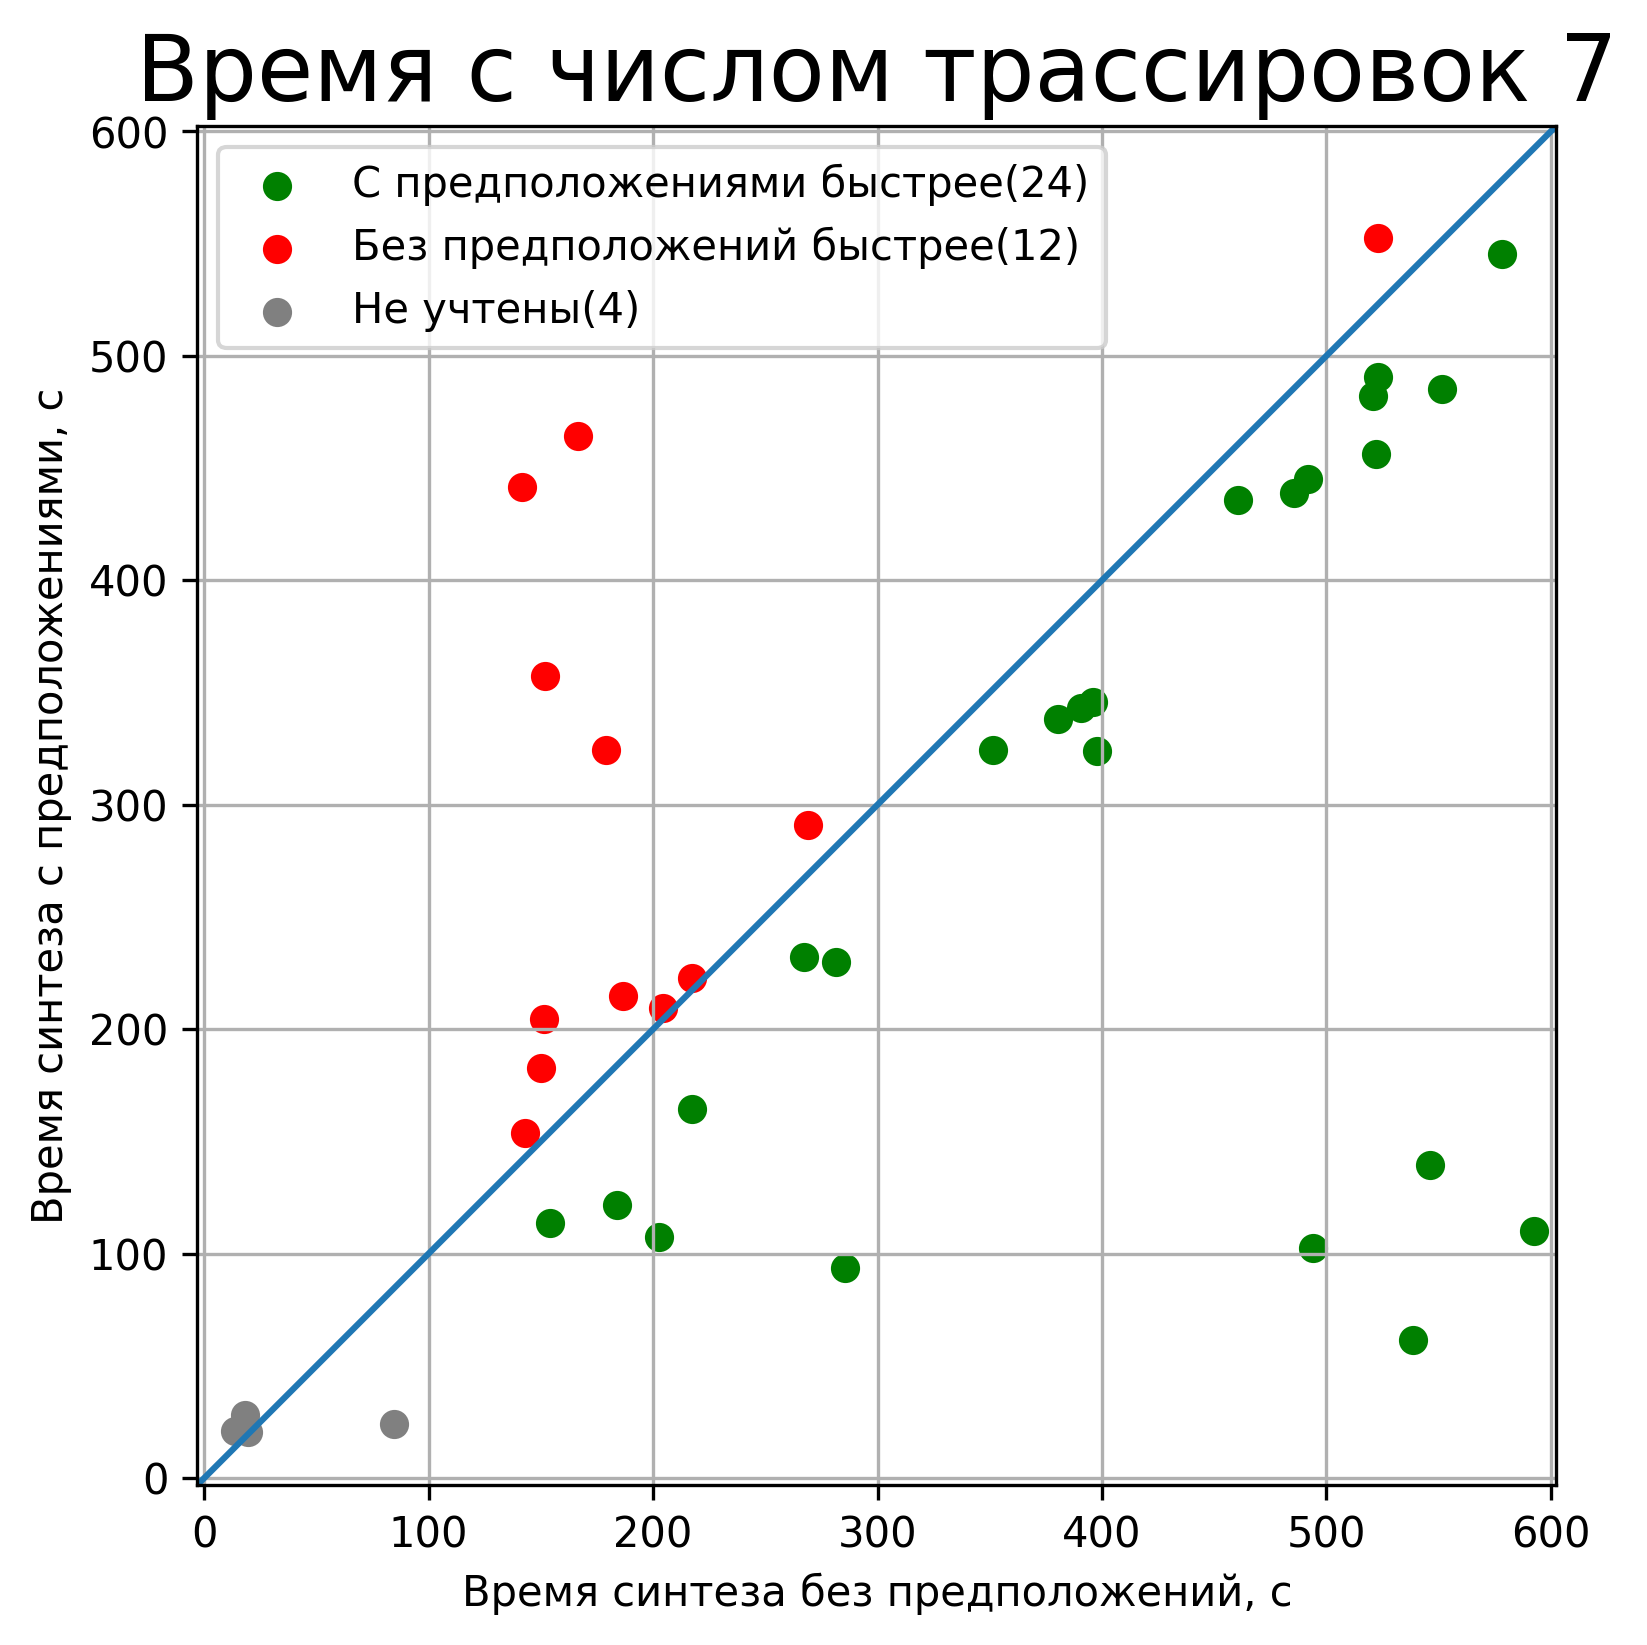

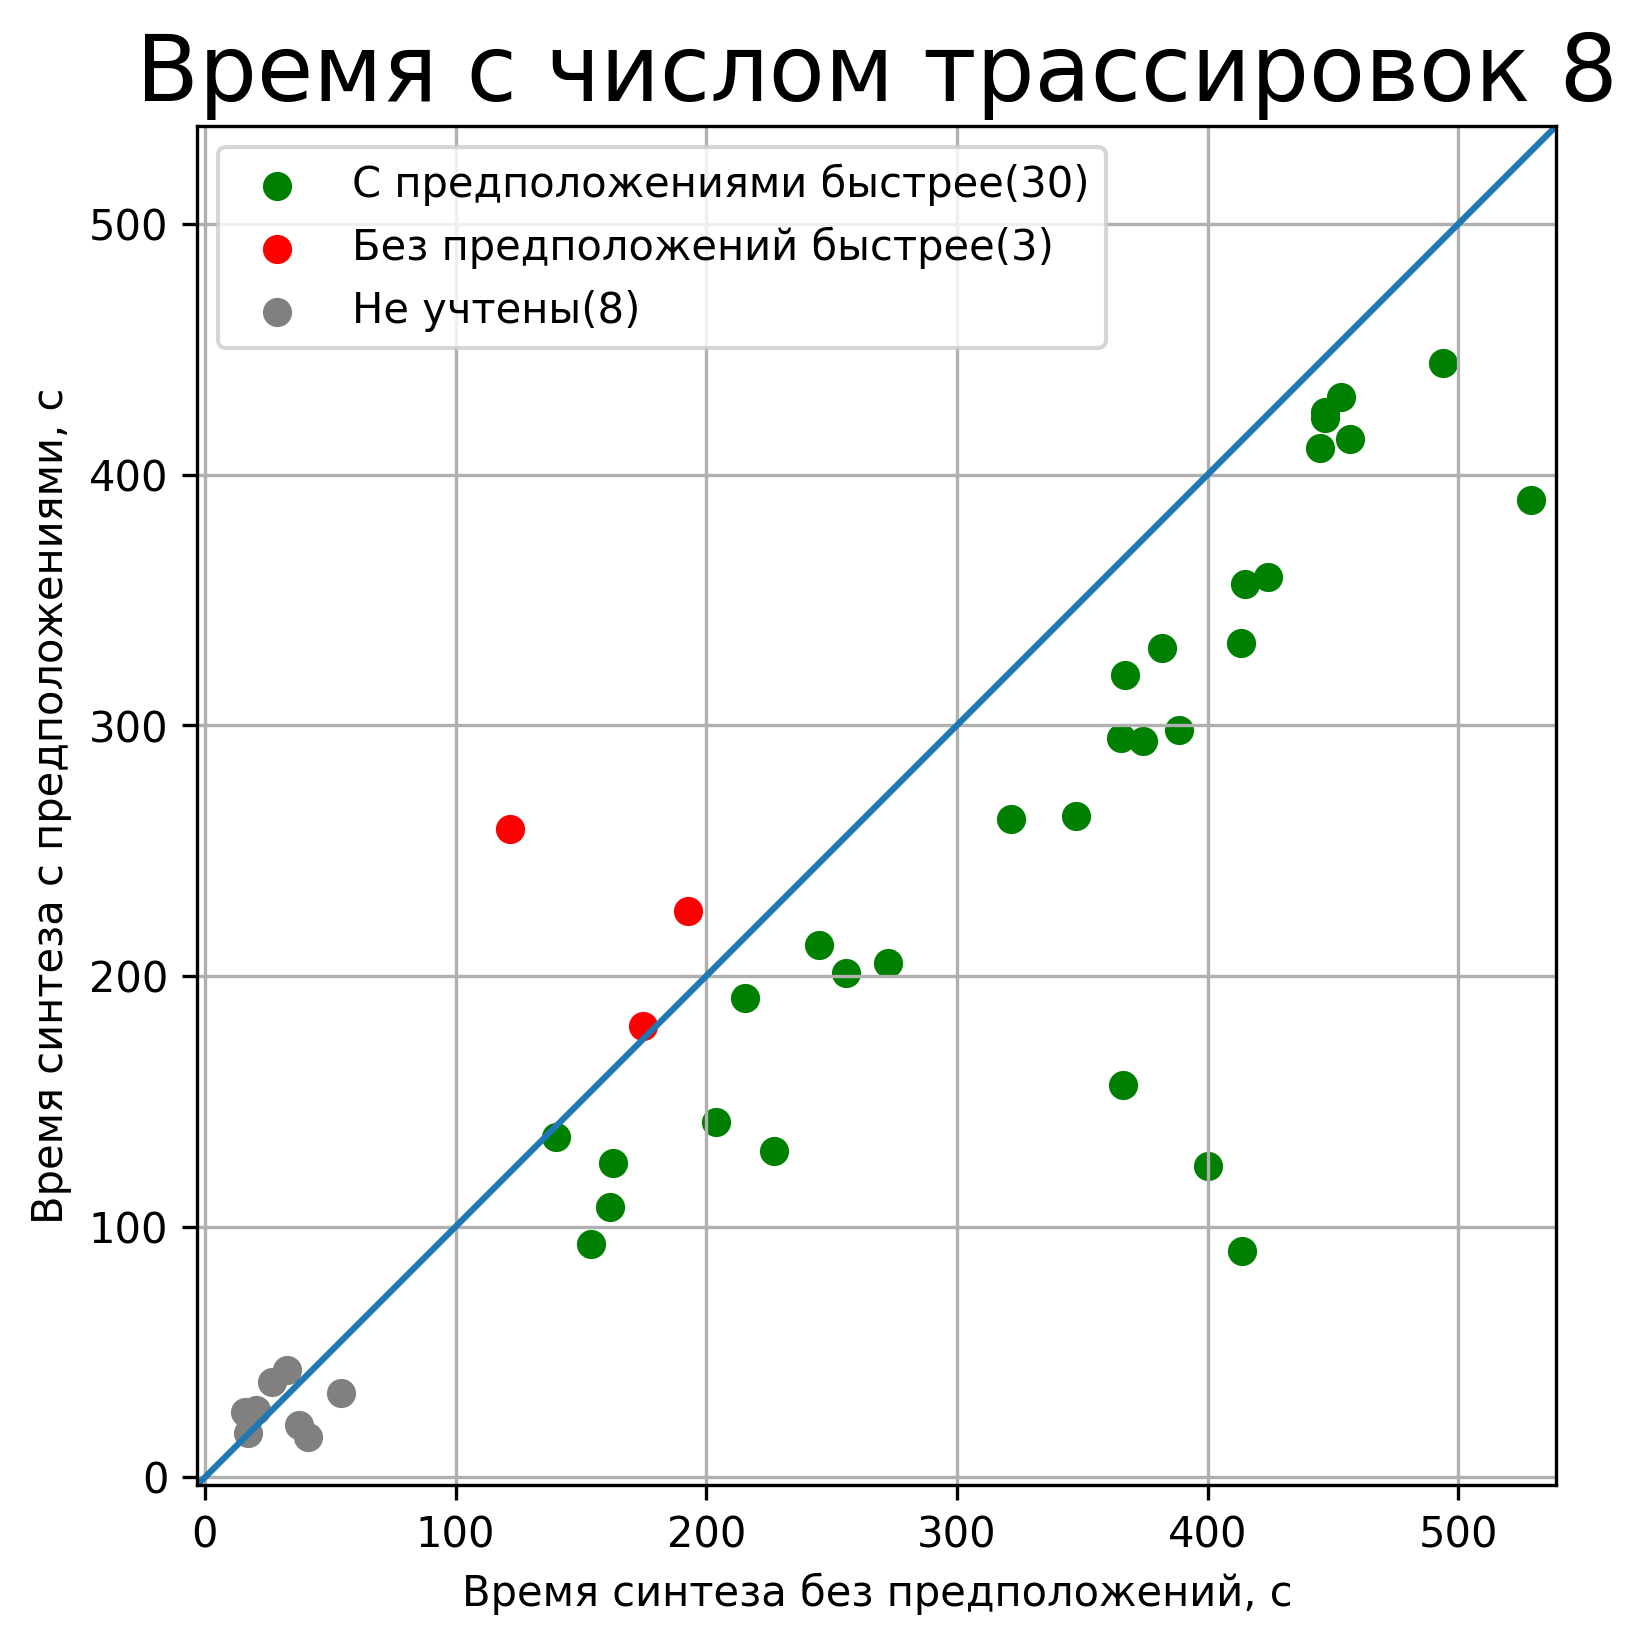

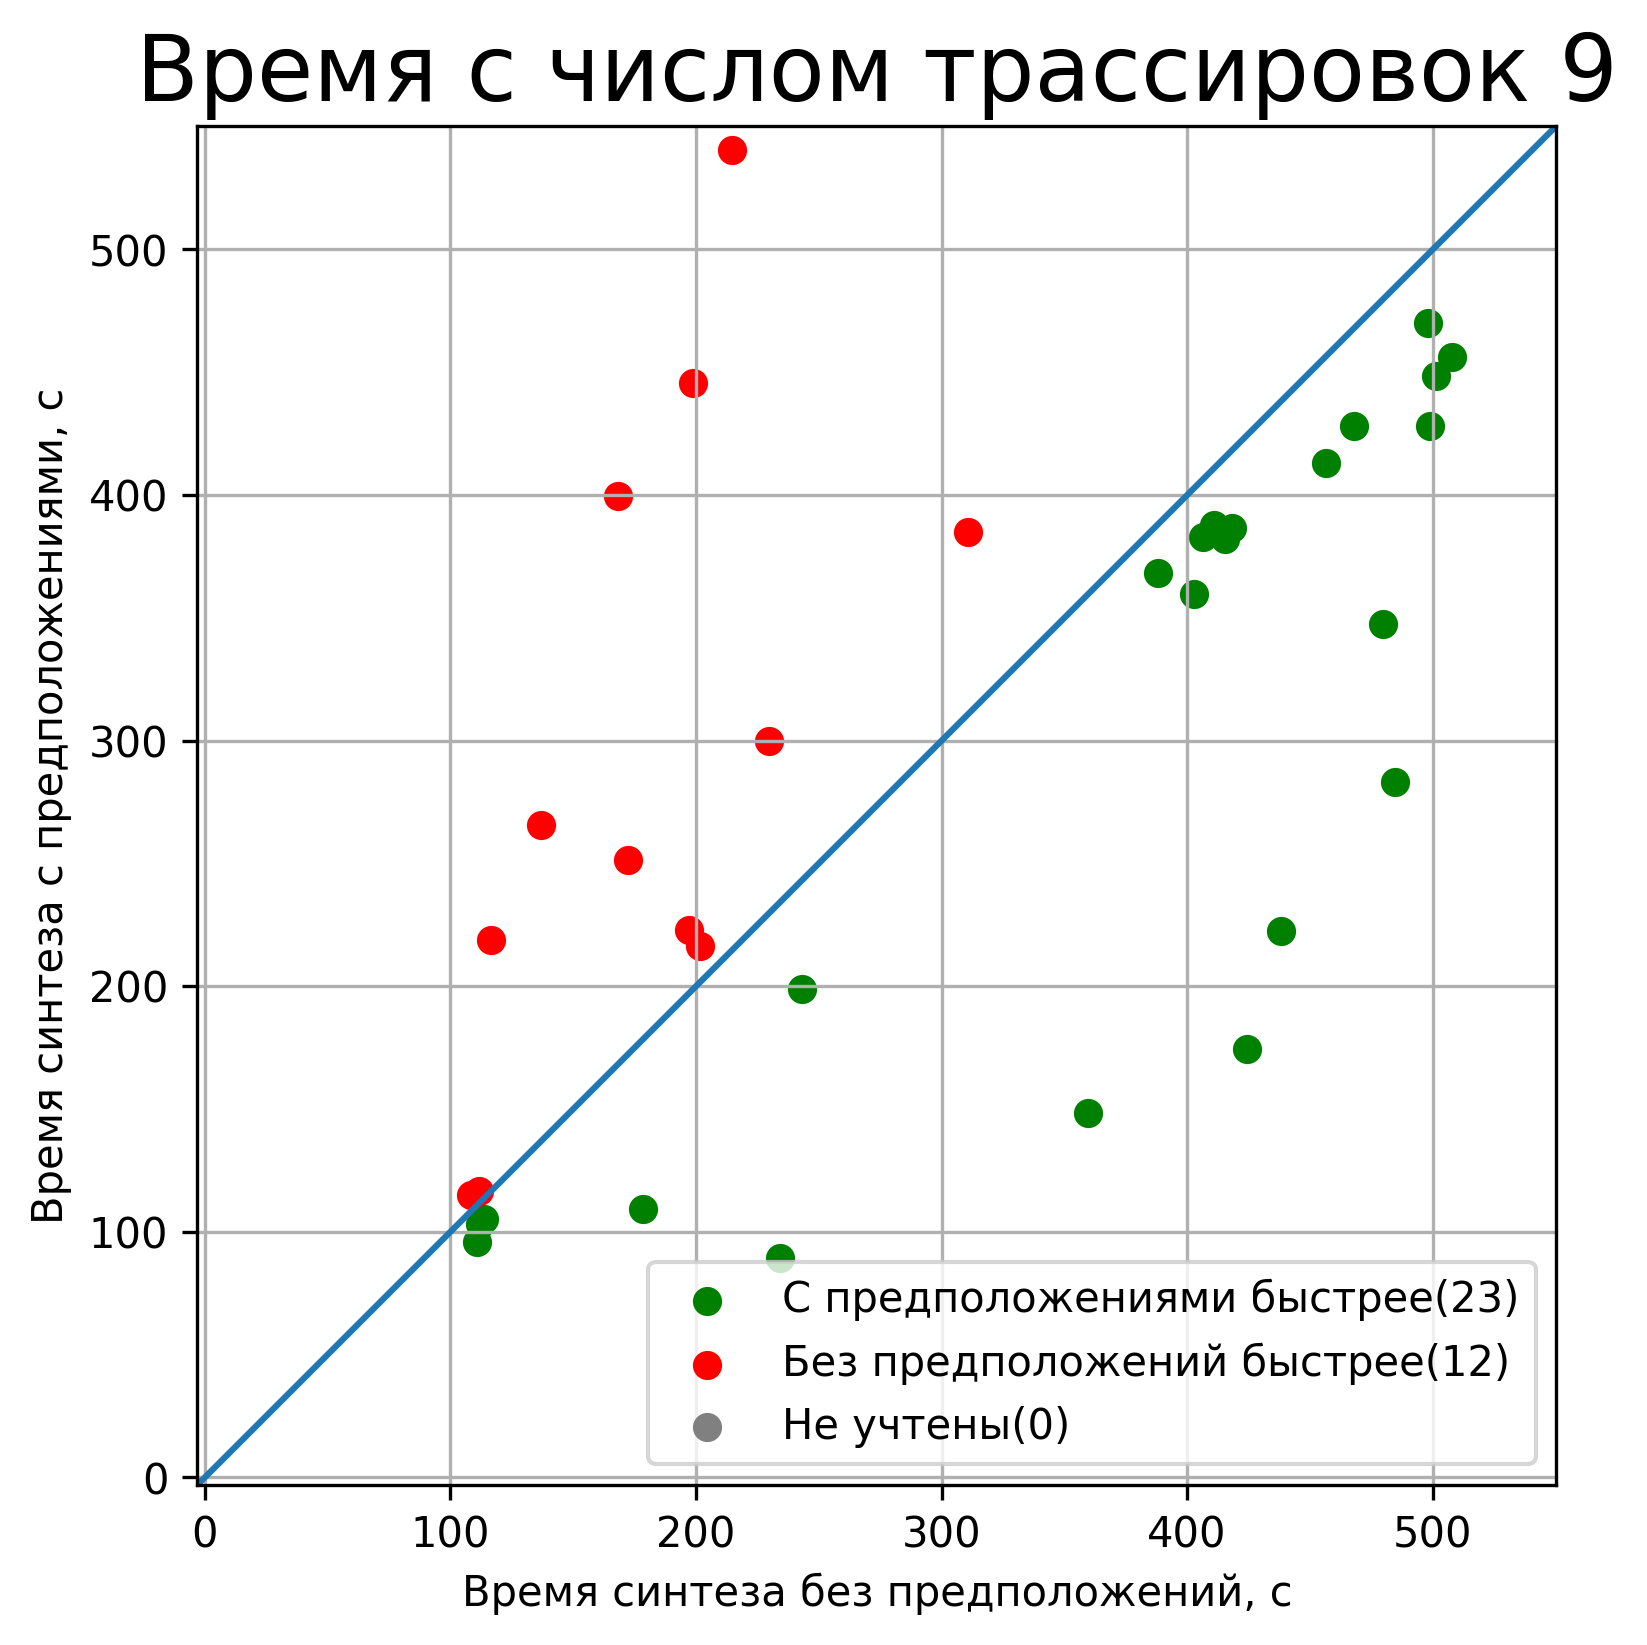

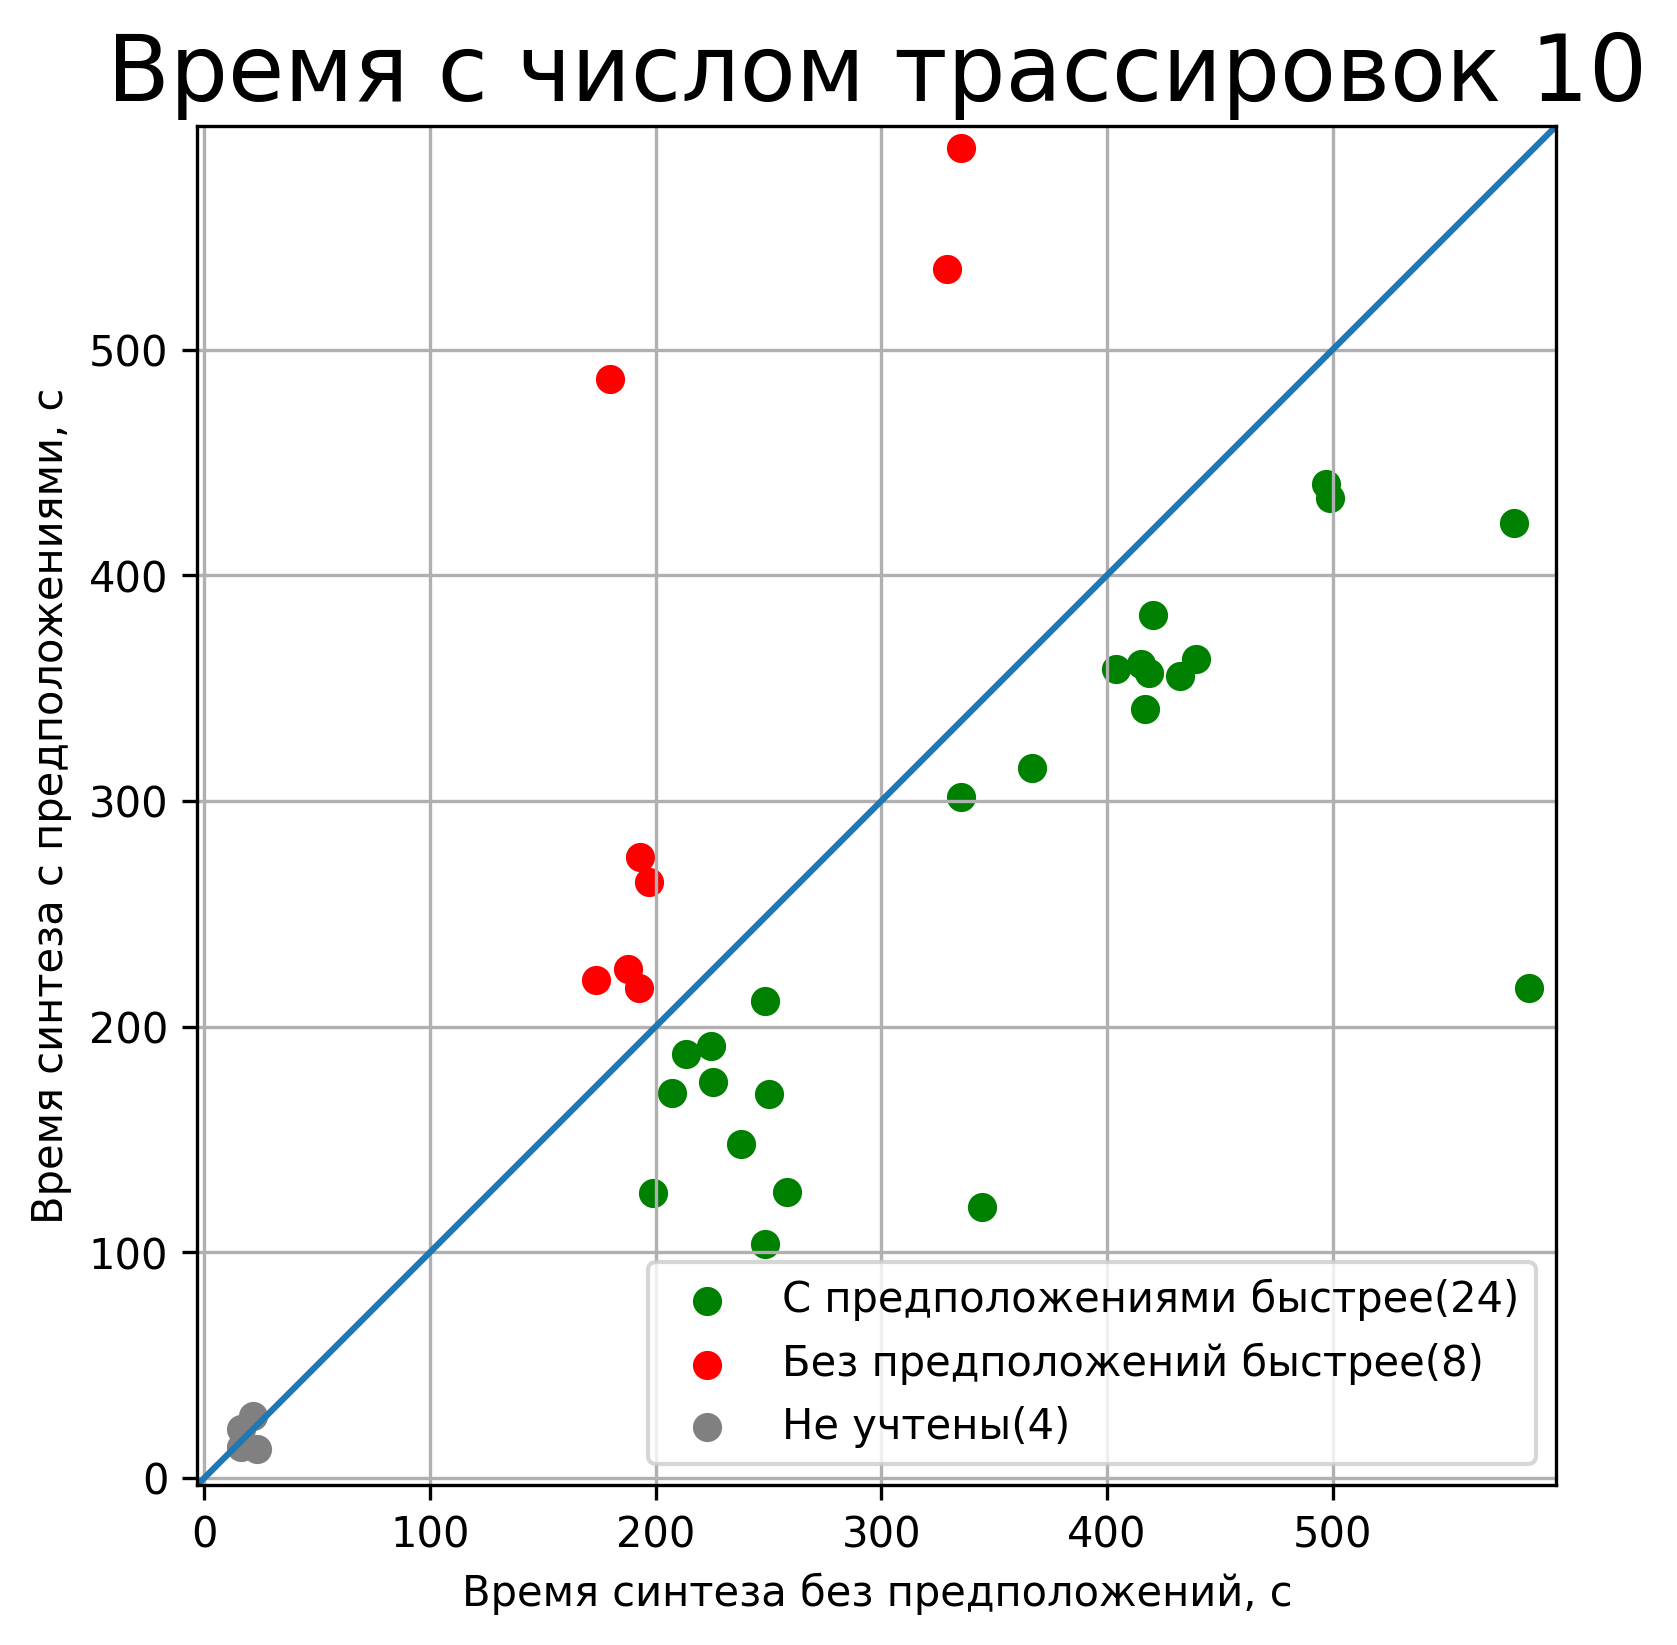

In [112]:
for i in range(1, 11):
    plt.figure(figsize=(8,6), dpi= 300)
    
    info = extract_info(stats, [(0, {i}), (4, {'assumptions_total_duration', 'general_total_duration'})])
    keys = list({k[:4] for k in info if info[k[:4] + ('assumptions_total_duration',)] is not None and info[k[:4] + ('general_total_duration',)] is not None})
    y = [info[k[:4] + ('assumptions_total_duration',)] for k in keys]
    x = [info[k[:4] + ('general_total_duration'    ,)] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y)

    plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    #plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
    plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    mx = max(max(x), max(y))
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

    plt.title(f'Время с числом трассировок {i}', fontsize=22)
    plt.xlabel('Время синтеза без предположений, с')
    plt.ylabel('Время синтеза с предположениями, с')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()